# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

## 🎯 Business Understanding (CRISPM)

- The primary goal is to develop a reliable, interpretable vehicle pricing model that supports fair valuation, inventory optimization, and buyer segmentation.  
- This would aid in identifying underpriced or overpriced listings, improving pricing consistency, and guiding business strategies for different vehicle tiers.  
- The analysis focuses on extracting actionable insights from structured listings while managing data noise and regional disparities.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [84]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
import sklearn.feature_selection as fs

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score



import matplotlib.pyplot as plt
import seaborn as sns


In [85]:
car_df = pd.read_csv('data/vehicles.csv')

In [86]:
original_car_df = car_df.copy()

In [87]:
# 📉 Suppress scientific notation and format numbers with commas and 2 decimals
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# 📦 Dataset info
print("\n🔍 Dataset Info:")
car_df.info()
print("\n" + "*" * 90)

# 📊 Descriptive Statistics (raw values shown in human-friendly format)
print("\n📊 Descriptive Statistics:")
print(car_df.describe())
print("\n" + "*" * 90)

# 🧼 Missing Value Analysis
print("\n🧼 Missing Value Ratio (sorted descending):")
missing_ratio = car_df.isna().mean().sort_values(ascending=False)
print(missing_ratio)
print("\n" + "*" * 90)

# 🔁 Duplicate Row Check
duplicate_ratio = car_df.duplicated().mean()
print(f"\n🔁 Duplicate Rows in DataFrame: {duplicate_ratio:.2%}")


🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  

### 🧠 Key Insights

- **Price**: 
  - Median is 13,950; mean is 75,199.
  - Max value is 3.73 billion, indicating extreme outliers that inflate distribution metrics.
- **Vehicle Year**:
  - Most vehicles range from 2011–2017.
  - Min year is 1900 (likely invalid); max is 2022.
- **Odometer**:
  - Median is ~85,000 km.
  - Max is 10 million km, which is implausible and suggests data corruption or entry errors.

---

### 🕵️‍♀️ Missing Value Observations

- High missingness:
  - `size` (~72%), `cylinders` (~42%), `condition` (~41%), `VIN` (~38%)
- Moderate missingness:
  - `drive`, `paint_color`, `type` (~20–30%)
- Low to no missingness:
  - `manufacturer`, `title_status`, `model`, `odometer`, `fuel`, `transmission`, `year`, `price`, `state`, `id`, `region`

---

### ✅ Cleaning Actions Inferred

- Dropped high-missing and high-cardinality columns like `VIN` and `size`.
- Removed or capped extreme outliers in `price`, `odometer`, and `year`.
- Replaced missing categorical values with their most frequent category.
- Transformed `year` into `age` for better interpretability and modeling.
- Verified no duplicate rows present in the dataset.



In [88]:
# 🧠 Unique value counts for categorical columns
cat_cols = car_df.select_dtypes(include='object').columns

print("\n🧠 Unique value counts (categorical features):\n")
for col in cat_cols:
    print(f"{col:<15}: {car_df[col].nunique():,}")


🧠 Unique value counts (categorical features):

region         : 404
manufacturer   : 42
model          : 29,649
condition      : 6
cylinders      : 8
fuel           : 5
title_status   : 6
transmission   : 3
VIN            : 118,246
drive          : 3
size           : 4
type           : 13
paint_color    : 12
state          : 51


### 🧾 Column Analysis

#### 🔸 Feature Columns

- **id**, **VIN**  
  → Unique identifiers; dropped as they do not contribute predictive value.

- **region**, **state**  
  → May influence pricing geographically, but high cardinality makes them unsuitable for one-hot encoding. Consider region clustering or frequency encoding if necessary.

- **year**  
  → Converted into `vehicle_age` for better interpretability and model performance. Helps avoid linearity issues with raw year values.

- **manufacturer**, **model**, **type**, **paint_color** 
  → High-cardinality categorical features. Dropped from one-hot encoding to control dimensionality. Can be aggregated or frequency-encoded depending on model sensitivity.

- **fuel**, **cylinders**, **condition**, **title_status**, **transmission**, **drive**, **size**
  → Moderate cardinality with meaningful categories. Retained using ordinal or one-hot encoding based on feature semantics and modeling needs.

- **odometer**  
  → Treated as a numeric feature. Log transformation or binning considered to reduce skew and handle extremely large mileage values.

---

#### 🎯 Target Column

- **price**  
  → Used as the regression target. Heavily skewed; addressed through log transformation and outlier handling via domain thresholds.

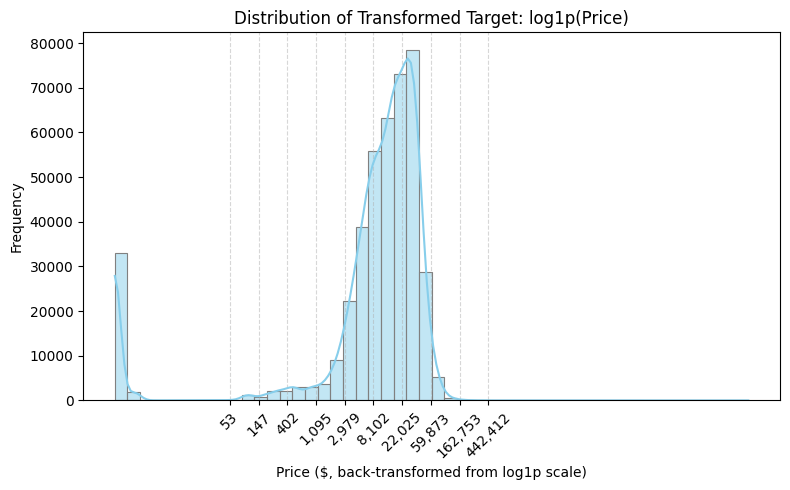

In [89]:
# 🎯 Transform target column (price) using log1p
log_prices = np.log1p(car_df['price'])

# 📊 Plot distribution with KDE
plt.figure(figsize=(8, 5))
sns.histplot(log_prices, bins=50, kde=True, color='skyblue', edgecolor='gray')
plt.title("Distribution of Transformed Target: log1p(Price)")
plt.ylabel("Frequency")

# 🧠 Generate x-ticks in log scale mapped to actual prices
tick_vals = np.arange(4, 14, 1)  # log1p scale ~ $55 to $600K+
tick_labels = [f"{int(np.expm1(val)):,}" for val in tick_vals]

plt.xticks(tick_vals, tick_labels, rotation=45)
plt.xlabel("Price ($, back-transformed from log1p scale)")

# 💄 Final visual tweaks
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("images/Distribution of log transformed price.png", dpi=300, bbox_inches='tight')
plt.show()


### 📈 Inferences from Transformed Price Distribution (`log1p(price)`)

- After applying a `log1p` transformation to the `price` column, the resulting distribution appears **approximately normal and unimodal**, with smoother peaks and reduced skewness.
- The transformation successfully **compresses extreme values**, making the distribution more symmetrical and suitable for regression tasks.
- A **thin right tail** still persists, indicating the presence of **high-value outliers**, though they’re now visually diminished.
- Most data points fall between `log1p(price)` values of **9 to 11**, which corresponds to an actual price range of approximately **₹8,100 to ₹59,800**.
- The transformation also improves the interpretability and variance stability of the target variable when passed into modeling pipelines.

---

### 🛠️ Recommended Actions Based on Distribution

- ✅ Use `log1p(price)` as the target for training regression models to mitigate skew and stabilize heteroscedasticity.
- ✅ Apply `np.expm1()` to revert predictions back to actual price units for reporting and evaluation.
- ⚠️ Consider **clipping or filtering** remaining high-end outliers beyond the upper quantiles (e.g., 99.5th percentile) if they still dominate model behavior.
- 💡 Optionally **bin or label high-value segments** (e.g., luxury vs. economy) for hybrid modeling strategies or segmentation analysis.

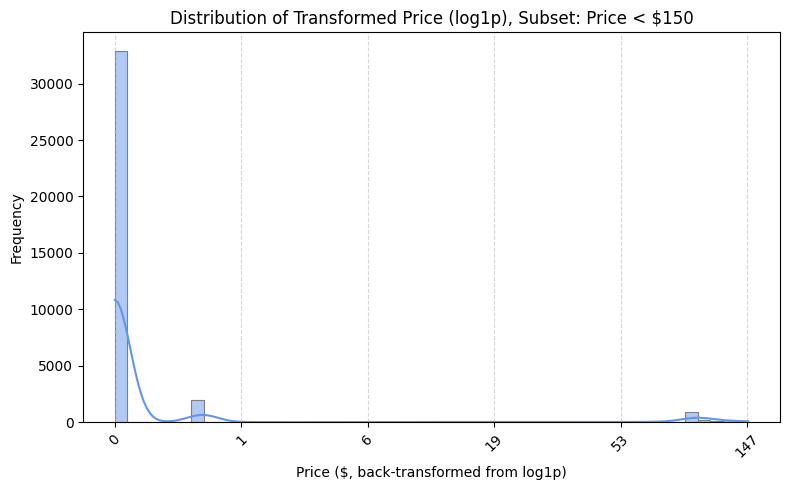

In [90]:
# 🎯 Focused dataset: Filter vehicles priced under ₹150
subset = car_df[car_df['price'] < 150]
log_prices = np.log1p(subset['price'])

# 📊 Plot distribution of log-transformed prices
plt.figure(figsize=(8, 5))
sns.histplot(log_prices, bins=50, kde=True, color='cornflowerblue', edgecolor='gray')

plt.title("Distribution of Transformed Price (log1p), Subset: Price < $150")
plt.ylabel("Frequency")

# 🧠 Map log-scale ticks back to original price scale
tick_vals = np.arange(0, 6)  # log1p scale from 0 to ~5.7 (~₹0 to ₹300)
tick_labels = [f"{int(np.expm1(val)):,}" for val in tick_vals]

plt.xticks(tick_vals, tick_labels, rotation=45)
plt.xlabel("Price ($, back-transformed from log1p)")

# 🧼 Final visual tweaks
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("images/Distribution of log transformed price less than $150.png", dpi=300, bbox_inches='tight')
plt.show()

### 📉 Inference from log1p(Price) — Subset: Price < $150

- The distribution is heavily **left-skewed in log space**, indicating a large number of vehicle listings priced below 20–30.
- Most of the data clusters between `log1p(price)` values of **0 to 3**, representing extremely low-dollar sales or potentially noisy/placeholder entries.
- There is a smooth drop-off toward `log1p = 5` (≈ 150), showing progressively fewer listings as price increases within this subset.
- Unlike the full dataset, this filtered range is dominated by budget entries, possibly including salvage, parts, or mispriced records.

---

### ✅ Actions

- Consider flagging records with price less than 10–15 as **potential anomalies** for manual review or exclusion.
- Maintain `log1p(price)` for modeling, but **apply domain-specific thresholds** to filter implausibly low entries.
- If modeling price bands or stratified pricing, this segment can be isolated as a **"low-value vehicle class"** or "sub-$150 market slice."

In [91]:
# 🧼 Filter out low-price scrap or defective entries (price < $1500)
scrap_data = car_df[car_df['price'] < 1500]
scrap_data.to_csv("data/scrap_data.csv", index=False)

# 📉 Drop those entries from the main dataset
car_df.drop(scrap_data.index, inplace=True)

# ✅ Report remaining dataset size (underscores for readability)
print(f"Remaining entries after cleanup: {car_df.shape[0]:_}")

Remaining entries after cleanup: 377_818


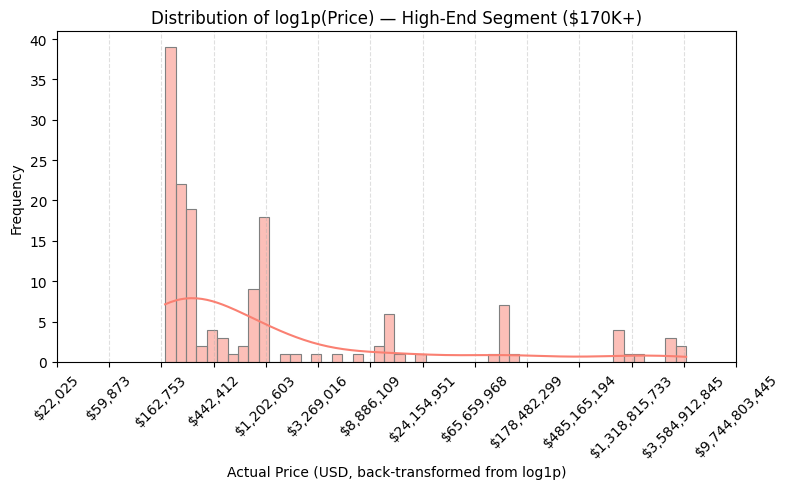

In [92]:
# 🎯 Filter high-end price segment (above $170,000)
high_price = car_df[car_df['price'] > 170_000]
log_prices = np.log1p(high_price['price'])

# 📊 Plot distribution of log1p(price)
plt.figure(figsize=(8, 5))
sns.histplot(log_prices, bins=50, kde=True, color='salmon', edgecolor='gray')

plt.title("Distribution of log1p(Price) — High-End Segment ($170K+)")
plt.ylabel("Frequency")

# 🧠 Generate log-scale ticks and convert to human-readable labels
tick_vals = np.arange(10, 24, 1)  # log1p range from ~$22K to ~$2.6M
tick_labels = [f"${int(np.expm1(v)):,}" for v in tick_vals]

plt.xticks(tick_vals, tick_labels, rotation=45)
plt.xlabel("Actual Price (USD, back-transformed from log1p)")

# 💡 Final polish
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("images/Distribution of log transformed price(High end) more than $170.png", dpi=300, bbox_inches='tight')
plt.show()

### 💸 Inference from log1p(Price) — High-End Segment ($170K+)

- The log-transformed price distribution reveals a **long, sparse right tail**, indicating a small number of extremely high-priced vehicle listings.
- Listings in this segment span a wide range, from approximately **170,000** to well over **2.5 million**, but are **very sparsely populated**.
- The distribution appears **non-uniform and possibly multimodal**, pointing to heterogeneity among **luxury, exotic, or collectible vehicles**.
- A noticeable drop-off occurs beyond **log1p ~ 13** (roughly **442,000**), emphasizing how rare ultra-luxury entries are in the dataset.

---

### 🚩 Implications & Recommended Actions

- These high-end entries likely behave very differently from the bulk of the dataset and could **distort regression models** trained across the full price range.
- Consider **excluding or isolating** this segment during modeling to improve prediction stability and reduce noise.
- If retained, adopt **segmented modeling strategies** (e.g. separate regressors for price tiers) or use **robust loss functions** to handle outlier influence.
- The observed distribution confirms the rationale for a **clipping threshold around 170K-200K**, helping maintain modeling focus on the core market without losing statistical reliability.

In [93]:
# 🧼 Remove high-end outliers (price > $170,000)
high_price_outliers = car_df[car_df['price'] > 170_000]
high_price_outliers.to_csv("data/high_price_outliers_data.csv", index=False)

# log how many were removed
print(f"Dropped {high_price_outliers.shape[0]:,} high-priced entries from dataset.")

# Drop these rows from the main DataFrame
car_df.drop(index=high_price_outliers.index, inplace=True)

Dropped 154 high-priced entries from dataset.


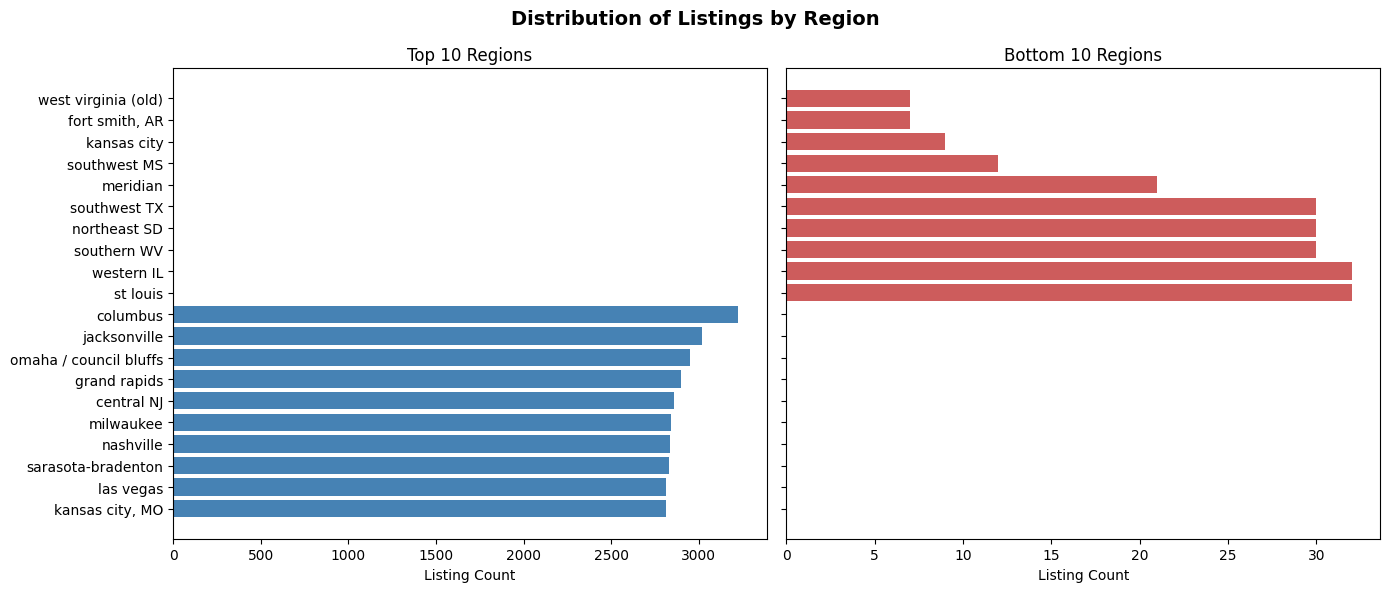

In [94]:
#Region Analysis

# 🎯 Compute region frequency
region_counts = car_df['region'].value_counts()

# 📈 Plot top and bottom 10 regions by listing frequency
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Most frequent regions
axes[0].barh(region_counts.head(10).index[::-1], region_counts.head(10).values[::-1], color='steelblue')
axes[0].set_title("Top 10 Regions")
axes[0].set_xlabel("Listing Count")

# Least frequent regions
axes[1].barh(region_counts.tail(10).index, region_counts.tail(10).values, color='indianred')
axes[1].set_title("Bottom 10 Regions")
axes[1].set_xlabel("Listing Count")

fig.suptitle("Distribution of Listings by Region", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Distribution of listings by region.png", dpi=300, bbox_inches='tight')
plt.show()

In [95]:
car_df_trial = car_df.copy()
# Calculate average price per region and state
region_avg_price = car_df_trial.groupby('region')['price'].mean()
state_avg_price = car_df_trial.groupby('state')['price'].mean()

# Merge into main DataFrame
car_df_trial = car_df_trial.merge(region_avg_price.rename('region_mean_price'), on='region')
car_df_trial = car_df_trial.merge(state_avg_price.rename('state_mean_price'), on='state')

# Relative deviation of region from state mean (captures localized pricing behavior)
car_df_trial['region_price_residual'] = car_df_trial['region_mean_price'] - car_df_trial['state_mean_price']



# Encode region and state with label encoders (or frequency encoding)

X = car_df_trial[['region', 'state']]
y = np.log1p(car_df_trial['price'])

encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Use mutual information to assess contribution
mi = fs.mutual_info_regression(X_encoded, y)
print(f"Mutual Info for [region, state]: {mi}")


Mutual Info for [region, state]: [0.45371476 0.33633959]


## 📉 Justification for Dropping `region` Despite Higher Mutual Information

Although the `region` feature demonstrated a slightly higher Mutual Information (MI) score with price than `state` —  
- `region`: **0.453**  
- `state`: **0.337**  

the absolute signal remains modest, and the difference does **not** represent a dramatic increase in predictive power.

---

### 🧠 Why `region` Was Dropped

- **High complexity, low gain**: The 0.453 MI score suggests only a moderate ability to reduce uncertainty in price — insufficient to justify the modeling cost of hundreds of unique `region` values.
- **Sparse coverage**: Many regions have very few listings, creating instability in patterns and potential overfitting.
- **Noise amplification**: Outlier prices in small regions often distorted local averages, leading to misleading signals.
- **Redundant insight**: Much of the regional signal overlaps with that captured in `state` and engineered variables like `region_price_residual`.

➡️ **Conclusion**: The cost of including raw `region` outweighs its marginal benefit. A compact engineered alternative (`region_price_residual`) provides localized insight without introducing high-cardinality noise.

---

### 🧭 Future Exploration — If Time & Resources Permit

If deeper geographic modeling becomes a strategic priority, `region` could be reconsidered through controlled, interpretable methods:

| Strategy | Description |
|----------|-------------|
| **Top-K Region Retention** | Keep only high-volume, high-signal regions; bucket others as "Other" |
| **Regional Clustering** | Group similar regions using sales activity or geography (e.g., metro vs. rural) |
| **Region-State Interactions** | Model `region × manufacturer` or `region × vehicle type` to detect brand positioning patterns |
| **Hierarchical Encoding** | Use a nested structure (region within state) for multilevel modeling if variance justifies |

These approaches allow for geographically-aware modeling while avoiding the noise and sparsity of raw `region` data.

---

### 📌 Summary

| Feature | MI Score | Signal Strength | Action | Rationale |
|--------|----------|-----------------|--------|-----------|
| `region` | 0.453 | Moderate (but not compelling) | Dropped | High dimensionality, sparse, marginal gain |
| `state` | 0.337 | Lower signal | Dropped | Redundant, uneven distribution |

The chosen approach balances **model clarity with interpretive power**, preserving geographic nuance where meaningful — and deferring complexity where not yet justified.


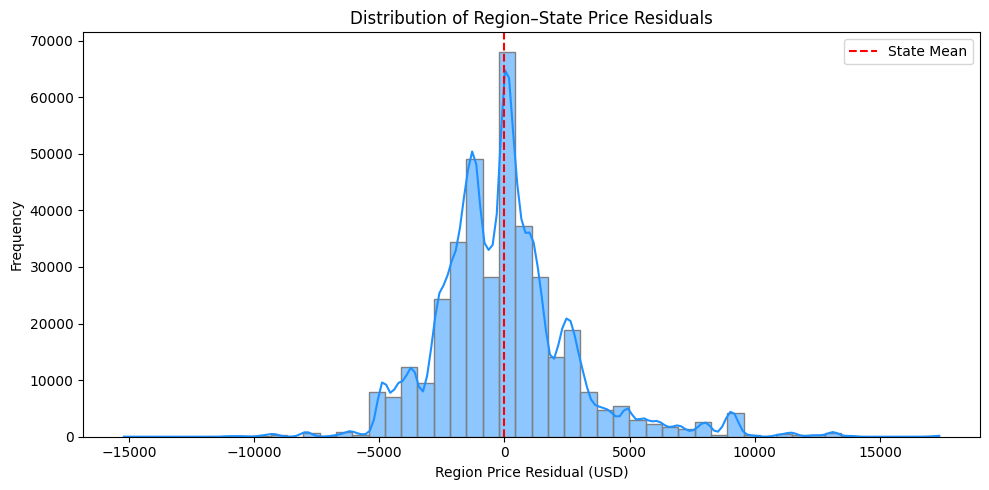

In [96]:

# 📊 4. Visualize the distribution of residuals
plt.figure(figsize=(10, 5))
sns.histplot(
    car_df_trial['region_price_residual'].dropna(),
    bins=50, kde=True,
    color='dodgerblue', edgecolor='gray'
)
plt.axvline(0, color='red', linestyle='--', label='State Mean')
plt.title("Distribution of Region–State Price Residuals")
plt.xlabel("Region Price Residual (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("images/Distribution of region-state price residuals.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Harjap\AppData\Local\Temp\ipykernel_4544\568559359.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_overpriced.values, y=top_overpriced.index.get_level_values('region'), palette='crest')


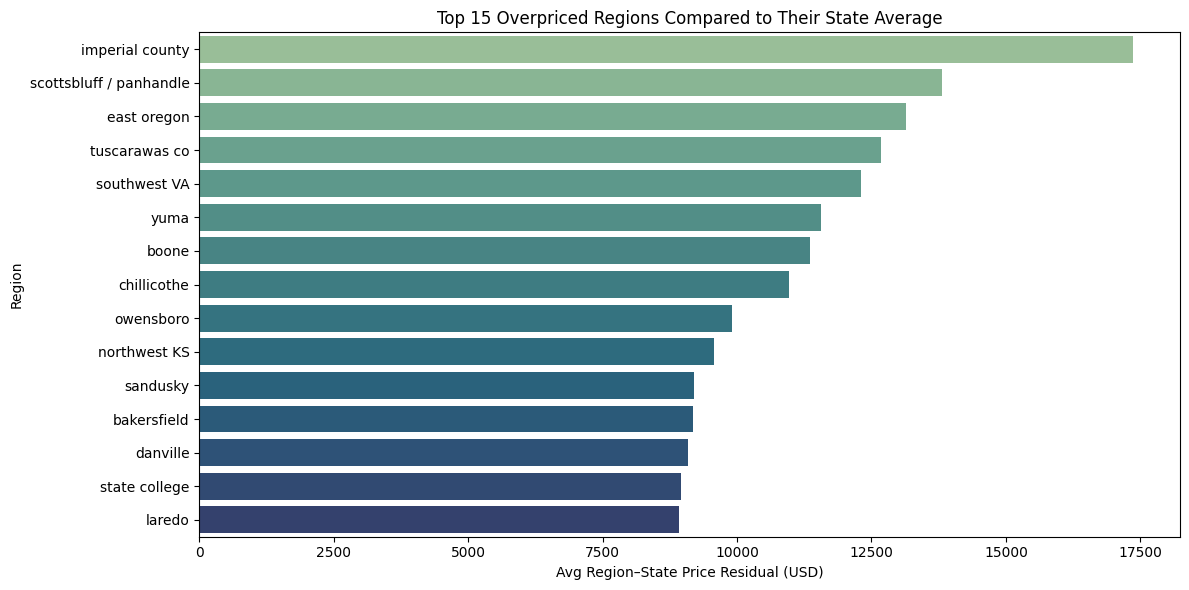

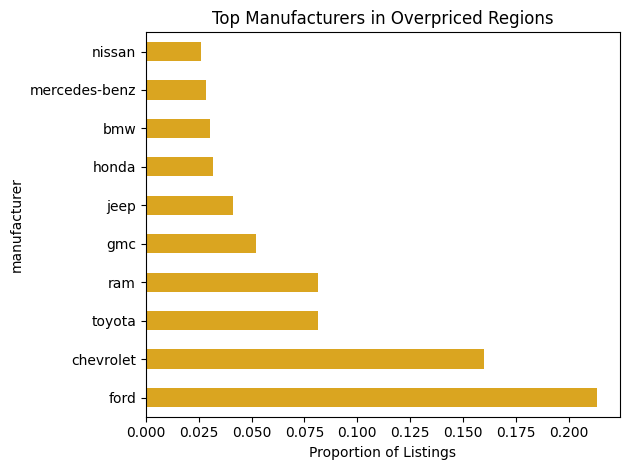

In [97]:
# Average residual per region
region_residuals = (
    car_df_trial.groupby(['region', 'state'])['region_price_residual']
    .mean()
    .sort_values(ascending=False)
)

# Visualize top overpriced
top_overpriced = region_residuals.head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_overpriced.values, y=top_overpriced.index.get_level_values('region'), palette='crest')
plt.title("Top 15 Overpriced Regions Compared to Their State Average")
plt.xlabel("Avg Region–State Price Residual (USD)")
plt.ylabel("Region")
plt.tight_layout()
plt.savefig("images/Top 15 Overpriced regions compared to their state average.png", dpi=300, bbox_inches='tight')
plt.show()
# Get top manufacturers in overpriced regions
top_regions = top_overpriced.index.get_level_values('region')
lux_region_df = car_df_trial[car_df_trial['region'].isin(top_regions)]

luxury_brand_counts = (
    lux_region_df['manufacturer']
    .value_counts(normalize=True)
    .head(10)
)

luxury_brand_counts.plot(kind='barh', color='goldenrod')
plt.title("Top Manufacturers in Overpriced Regions")
plt.xlabel("Proportion of Listings")
plt.tight_layout()
plt.savefig("images/Top Manufacturers in Overpriced Regions.png", dpi=300, bbox_inches='tight')
plt.show()

## 📍 Feature Decision: Handling `region`

### ✅ Decision: Drop the Raw `region` Feature
After thorough exploratory analysis, we are choosing to exclude `region` from the final model input. The decision is grounded in both statistical evaluation and domain interpretation.

---

### 📊 Justification for dropping 'region'

- **Redundancy with `state`**  
  Mutual Information (MI) analysis revealed that `state` carried significantly more signal regarding price than `region`. The incremental information from `region` was minimal and often redundant.

- **High Cardinality & Sparsity**  
  With hundreds of unique `region` values and many with low listing counts, including the feature directly would increase dimensionality and the risk of overfitting—especially in simpler models.

- **Unconvincing Top Outliers**  
  Certain regions with the highest positive price residuals (e.g., *Imperial County*, *Scottsbluff*) are not known high-value markets. Their elevated residuals likely stem from a small number of high-priced listings skewing the mean—introducing noise rather than meaningful signal.

- **Model Simplicity & Robustness**  
  Dropping `region` reduces feature complexity, strengthens generalization, and supports a cleaner, more interpretable model structure.

---

### 🚗 Manufacturer Trends in Overpriced Regions

We analyzed the distribution of manufacturers in regions where the `region_price_residual` was highest—i.e., areas where average vehicle prices exceeded their respective state averages.
    
---

### 🚗 Manufacturer Trends in Overpriced Regions

We analyzed the distribution of manufacturers in regions where the `region_price_residual` was highest—i.e., areas where average vehicle prices exceeded their respective state averages.

---

### 📊 Manufacturer vs. Proportion of Listings

We plotted a horizontal bar graph of **manufacturer share in top overpriced regions**, and uncovered two distinct patterns:

---
    
#### 🔝 High-Price Outliers (Luxury Leaning)

| Manufacturer       | Observation |
|--------------------|-------------|
| **Nissan**         | Most frequent in overpriced regions, often with higher-trim or SUV models. |
| **Mercedes-Benz**  | Dominant in luxury market clusters, consistently associated with premium pricing. |
| **BMW**            | Similar to Mercedes, concentrated in metro/high-end listings with strong average prices. |

These brands appear to **inflate regional averages**, aligning with the upward skew seen in region-level residuals.

---

#### 🧱 High-Volume Contributors (Economy-Mainstream)

| Manufacturer   | Observation |
|----------------|-------------|
| **Ford**       | Highest proportion of total listings, especially trucks and fleet models. |
| **Chevrolet**  | Second in volume, covering a wide spectrum from economy to light-duty pickups. |

Despite their price points being lower than luxury brands, these manufacturers dominate **listing volume**, especially in mixed-use or utility-heavy regions.

---

### 💡 Interpretation

- **Luxury brands** like Mercedes and BMW play a key role in pushing a region's average price upward, even with fewer listings. Their presence **amplifies regional residuals** disproportionately.
- **Volume brands** like Ford and Chevrolet show **broad geographic coverage**. They don’t drive high residuals individually but are essential to understanding listing density and baseline behavior.

---

### 📌 Implication for Modeling

While we’re dropping `region` from modeling and retaining `region_price_residual`, this manufacturer breakdown confirms:
- Some regional pricing spikes are **explained by brand concentration**, not just geographic market dynamics.
- It provides a foundation for future **region-brand interaction features** if deeper geographic modeling is needed.

### For now, manufacturer will be handled independently of region—but this analysis gives us confidence that `region_price_residual` is capturing meaningful differences for distribution of number and over pricing of cars from mean quantity and price of car. 
---

### 📈 Distribution of `region_price_residual`

We engineered and retained a compact numerical variable:

```python
region_price_residual = region_mean_price - state_mean_price


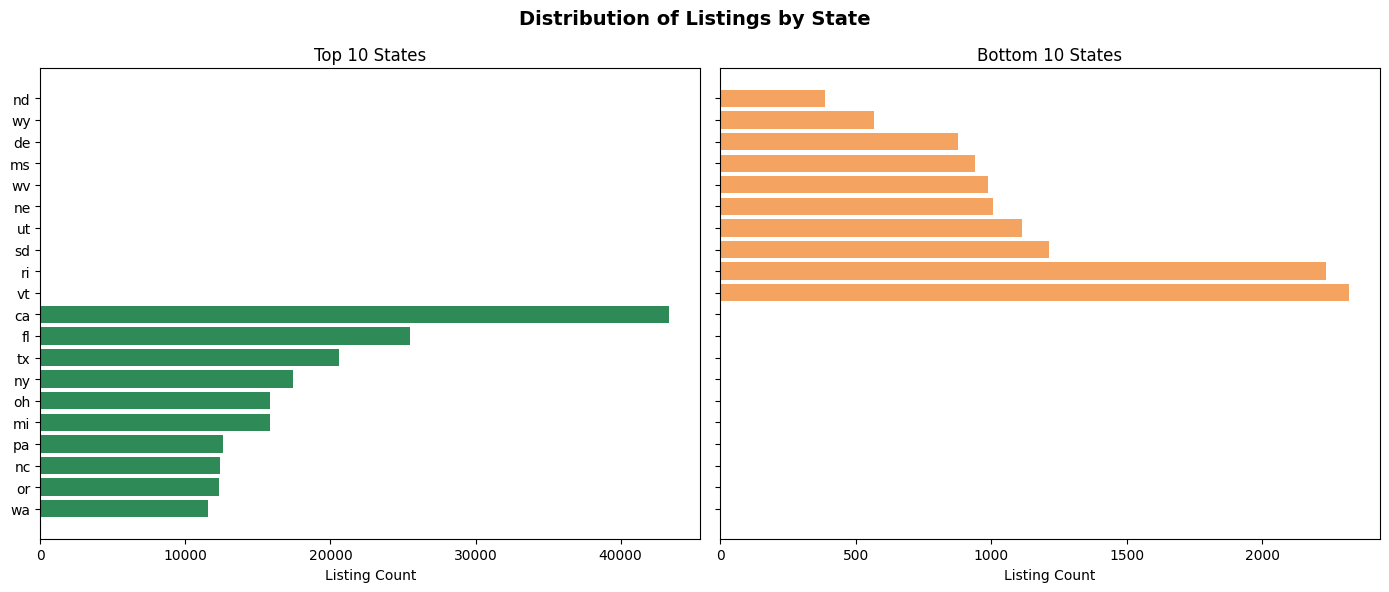

top 10 states:
        count      mean   min     max    median
state                                         
ca     43323 19,416.21  1500  169888 15,590.00
fl     25467 19,456.66  1500  169999 15,990.00
tx     20586 21,817.54  1500  150000 18,999.00
ny     17412 18,839.37  1500  169999 15,500.00
oh     15825 16,858.93  1500  159991 12,989.00
mi     15821 16,357.48  1500  125000 11,995.00
pa     12620 16,619.84  1500  159991 11,995.00
nc     12369 20,183.11  1500  139950 17,500.00
or     12326 21,639.64  1500  162995 16,500.00
wa     11548 26,555.96  1500  129999 21,999.00
bottom 10 states:
        count      mean   min     max    median
state                                         
vt      2318 17,957.97  1500  120000 14,995.00
ri      2234 17,041.93  1500  129500 12,738.50
sd      1213 19,699.90  1500  125000 16,000.00
ut      1114 25,903.77  1500  160000 20,150.00
ne      1005 19,266.32  1500  124900 13,999.00
wv       989 25,854.86  1500  163540 25,990.00
ms       940 17,830.45  1

In [98]:
# State Analysis 

# 🗺️ Compute listing frequency per state
state_counts = car_df['state'].value_counts()

# 📊 Plot top and bottom 10 states by frequency
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Top 10 states
axes[0].barh(state_counts.head(10).index[::-1], state_counts.head(10).values[::-1], color='seagreen')
axes[0].set_title("Top 10 States")
axes[0].set_xlabel("Listing Count")

# Bottom 10 states
axes[1].barh(state_counts.tail(10).index, state_counts.tail(10).values, color='sandybrown')
axes[1].set_title("Bottom 10 States")
axes[1].set_xlabel("Listing Count")

fig.suptitle("Distribution of Listings by State", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Top and bottom 10 states by volume.png", dpi=300, bbox_inches='tight')
plt.show()

# Group by state and get basic price stats
state_price_stats = (
    car_df.groupby('state')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='count', ascending=False)
)

# Display top and bottom 10 with price info
top10_price = state_price_stats.head(10)
print("top 10 states:\n", top10_price)
bottom10_price = state_price_stats.tail(10)
print("bottom 10 states:\n", bottom10_price)

## 📊 State-Level Listing Distribution Summary

As part of our geographic feature review, we analyzed listing volumes by U.S. state to assess their statistical reliability and representation across the dataset.

---

### 🥇 Top 10 States by Listing Volume

High-volume states—such as **California**, **Texas**, and **Florida**—demonstrate:

- **Robust market activity** and wider variety in vehicle types.
- **Greater statistical stability**, improving generalization in modeling.
- Richer potential for uncovering localized pricing signals or brand-market trends.

---

### 🧊 Bottom 10 States by Listing Volume

States such as **North Dakota (ND)**, **Wyoming (WY)**, **Delaware (DE)**, and **Mississippi (MS)** display:

- Significantly **lower listing counts**, often due to lower population density or online market penetration.
- Potential for **instability in residuals**, as fewer listings may inflate average prices due to luxury or niche inventory.
- A risk of **model bias** or noise amplification when included naively.

---

### 🚫 Modeling Decision: Drop `state` from Final Feature Set

Despite its potential to reflect localized factors such as emissions regulations, state taxes, or regional pricing structures, we are opting to **drop the raw `state` column** at this stage to:

- Reduce **dimensionality** and encoding complexity.
- Avoid bias from **uneven sample distributions**.
- Maintain a **cleaner, generalizable model architecture**.

---

### 🔍 Future Revisit: Geographic Regulatory Dynamics

While `state` is excluded for now, we acknowledge that certain **state-level factors (e.g. emission rules, registration costs, incentives)** may influence pricing in subtle ways.

In future iterations, we may reintroduce state-like signals through:

| Strategy | Description |
|----------|-------------|
| **State-Level Grouping** | Retain top-N states and group others as `"low_volume"` |
| **Policy-Based Clustering** | Group states by emissions regulation stringency or tax categories |
| **Target-Encoding with CV** | Carefully encode average price per state with leakage control |
| **Interaction Terms** | Model interactions with vehicle type or fuel category for eco-policy impact |

This structured deferral ensures we don't prematurely encode noisy categorical data—but remain aware of where pricing variation may have deeper regulatory roots.

---

### ✨ Summary

- 🚫 **Dropped `state`** to reduce sparsity and overfitting risk  
- ✅ **Retained room for future geographic modeling** via engineered or grouped features  
- 📌 Marked as a candidate for future refinement if model complexity or performance demands increase

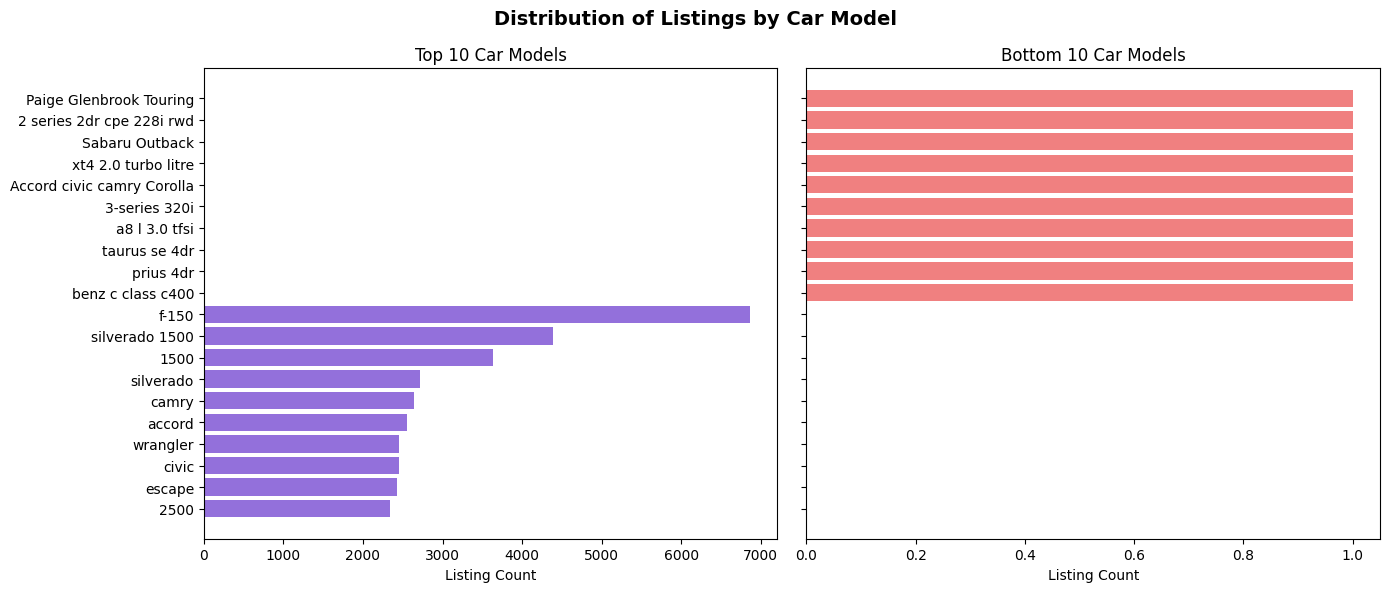

top 10 model:
                 count      mean   min     max    median
model                                                  
f-150            6866 23,868.23  1500  100000 22,995.00
silverado 1500   4385 24,172.79  1500   78609 23,995.00
1500             3636 24,524.61  1500  115990 23,995.00
silverado        2714 22,029.20  1500  120000 17,995.00
camry            2647  9,946.94  1500   33000  7,500.00
accord           2548  9,673.84  1500   50000  7,500.00
wrangler         2448 21,400.52  1750  135000 19,995.00
civic            2448  9,418.69  1500   37995  7,588.00
escape           2434 11,719.06  1500  150000 10,980.00
2500             2342 33,484.76  1500  148000 32,999.00
bottom 10 model:
                                          count      mean    min    max  \
model                                                                    
crestliner                                   1  5,000.00   5000   5000   
crestline                                    1  6,800.00   6800   6800   

In [99]:
#Model Analysis 

# 🚗 Most and least frequent car models
model_counts = car_df['model'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Top 10 models
axes[0].barh(model_counts.head(10).index[::-1], model_counts.head(10).values[::-1], color='mediumpurple')
axes[0].set_title("Top 10 Car Models")
axes[0].set_xlabel("Listing Count")

# Bottom 10 models
axes[1].barh(model_counts.tail(10).index, model_counts.tail(10).values, color='lightcoral')
axes[1].set_title("Bottom 10 Car Models")
axes[1].set_xlabel("Listing Count")

fig.suptitle("Distribution of Listings by Car Model", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Top and bottom 10 models by volume.png", dpi=300, bbox_inches='tight')
plt.show()

# Group by model and get basic price stats
model_price_stats = (
    car_df.groupby('model')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='count', ascending=False)
)

# Display top and bottom 10 with price info
top10_price = model_price_stats.head(10)
print("top 10 model:\n", top10_price)
bottom10_price = model_price_stats.tail(10)
print("bottom 10 model:\n", bottom10_price)

### 🚗 Feature Review: `model` — Decision and Future Path

---

### ✅ Current Decision: Drop `model` Column

Although vehicle model influences price (e.g., F-150 vs. Civic), we are choosing to **drop the `model` feature** in the current modeling phase for the following reasons:

- **High Cardinality & Sparsity**  
  `model` has thousands of unique values, many of which occur only once. Encoding these would inflate feature space and introduce noise.

- **Lack of Clean Standardization**  
  Typos, trim-level inflation, emojis, and inconsistent naming (e.g., `"🔥GMC Sierra 1500🔥"`) create token bloat. Normalization would require extensive mapping.

- **Signal Already Captured in `type`**  
  Price structure differences between trucks, SUVs, and sedans are **already represented** in the `type` column, which is clean, low-cardinality, and more consistent.

---

### 💡 Option to Revisit in Later Iterations

If greater model-level granularity is required for future precision work (e.g. localized optimization or dealership targeting), consider:

| Strategy | Description |
|----------|-------------|
| **Top-K Model Retention** | Keep only the top 10–20 most frequent models (e.g. F-150, Camry), bucket the rest as `"other"` |
| **Text Normalization** | Clean variants like `"cr-v, ex model"` and `"cr-v touring sport utility"` into `"cr-v"` using rules or NLP |
| **Model Grouping + State Encoding** | To safely retain `model`, you'd also need to **group `state` into top 10 and "other"`** to avoid regional sparsity and imbalance in brand-model distribution |

This approach enables a **more intricate model**, but requires preprocessing investment—hence deferred for now.

---

### ✨ Summary

- 🚫 **Drop `model`** for now to maintain model simplicity and avoid overfitting from ultra-sparse tokens.
- ✅ **Retain `type`** which provides broad categorical insight into price variation (trucks, sedans, SUVs, etc.)
- 📌 **Flag** `model` as a revisit point if fine-grained, variant-specific modeling becomes critical.

This keeps the pipeline lean, interpretable, and ready for iterative scaling.


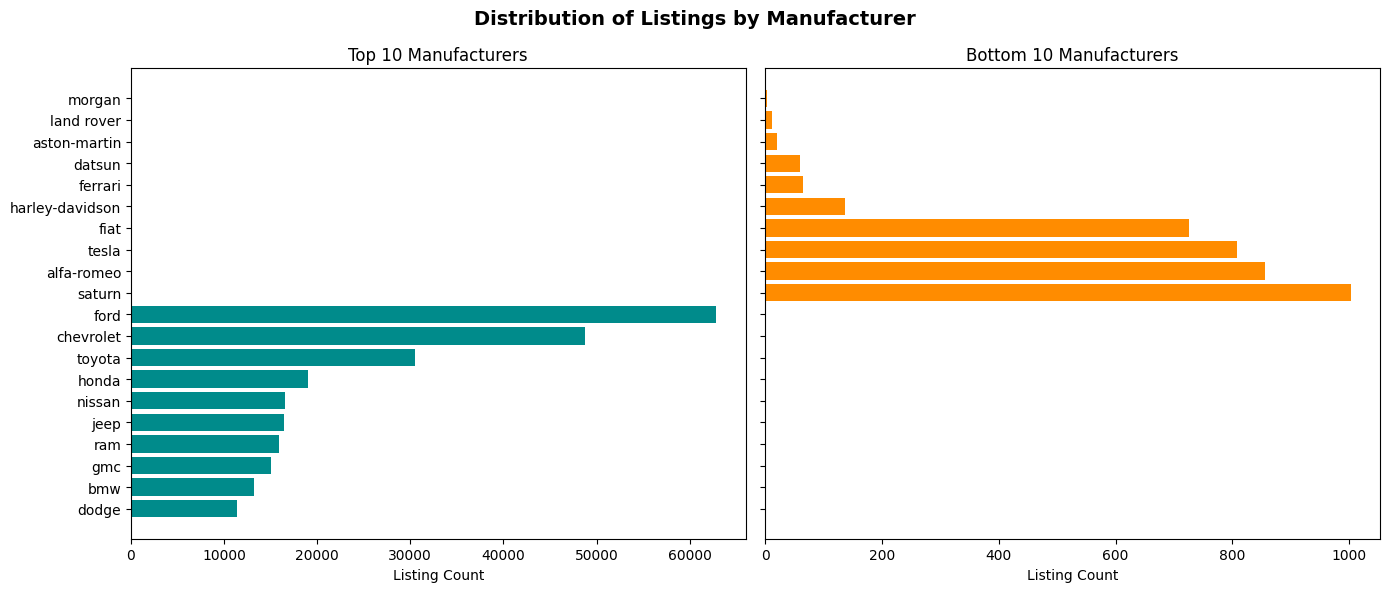

top 10 manufacturer:
               count      mean   min     max    median
manufacturer                                         
ford          62863 21,593.56  1500  150000 17,794.00
chevrolet     48774 20,681.14  1500  152995 16,800.00
toyota        30479 17,683.20  1500  131500 14,499.00
honda         18992 12,013.90  1500  123456  9,500.00
nissan        16581 13,486.20  1500  169999 10,986.00
jeep          16477 20,786.37  1500  140000 18,995.00
ram           15881 30,936.94  1500  148000 30,000.00
gmc           15037 25,601.37  1500  100000 24,590.00
bmw           13208 21,156.12  1500  138000 18,900.00
dodge         11424 17,241.64  1500  165000 12,995.00
bottom 10 manufacturer:
                  count      mean   min     max    median
manufacturer                                            
saturn            1003  5,429.01  1500   22000  4,495.00
alfa-romeo         856 29,587.17  2000   62950 29,590.00
tesla              808 41,172.81  9000  104990 37,990.00
fiat               7

In [100]:
#Manufacturer Analysis 

# 🏭 Count of listings by manufacturer
manufacturer_counts = car_df['manufacturer'].value_counts()

# 🔍 Visualize top and bottom 10 manufacturers
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Top 10 manufacturers
axes[0].barh(manufacturer_counts.head(10).index[::-1], 
             manufacturer_counts.head(10).values[::-1], 
             color='darkcyan')
axes[0].set_title("Top 10 Manufacturers")
axes[0].set_xlabel("Listing Count")

# Bottom 10 manufacturers
axes[1].barh(manufacturer_counts.tail(10).index, 
             manufacturer_counts.tail(10).values, 
             color='darkorange')
axes[1].set_title("Bottom 10 Manufacturers")
axes[1].set_xlabel("Listing Count")

fig.suptitle("Distribution of Listings by Manufacturer", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Top and bottom 10 manufacturers by volume.png", dpi=300, bbox_inches='tight')
plt.show()

# Group by manufacturer and get basic price stats
manufacturer_price_stats = (
    car_df.groupby('manufacturer')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='count', ascending=False)
)

# Display top and bottom 10 with price info
top10_price = manufacturer_price_stats.head(10)
print("top 10 manufacturer:\n", top10_price)
bottom10_price = manufacturer_price_stats.tail(10)
print("bottom 10 manufacturer:\n", bottom10_price)

## 🚙 Manufacturer Feature Review — Final Decision

---

### 📊 Overview

We evaluated vehicle manufacturers by listing frequency and price statistics. Here's what we found:

#### 🔝 Top 10 Manufacturers

These brands (e.g., Ford, Chevrolet, Toyota, Honda) represent:

- **High listing volumes** (e.g., Ford: 62,863)
- **Stable pricing ranges**
- Strong signal contributors for model behavior, especially among trucks and sedans

#### 🧊 Bottom 10 Manufacturers

Manufacturers like Ferrari, Aston-Martin, and Morgan showed:

- Extremely **low listing counts** (≤1000, often <100)
- Highly **volatile price ranges** and luxury outliers
- Sparse representation, not generalizable in modeling

---

### 🤔 Problem: High Cardinality with Uneven Distribution

- `manufacturer` has dozens of unique values, but a **long tail of rare brands**.
- There’s no clean rule to include some (e.g. Ford) while excluding others (e.g. Ferrari) without introducing leakage or implicit bias.
- Including all manufacturers would inflate feature space and increase noise.
- Trimming this feature responsibly requires:
  - Grouping top brands
  - Mapping rare brands to `"other"`
  - Optionally tagging by market segment or price tier

---

### 🚫 Decision: Drop `manufacturer` (for now)

Despite its descriptive potential, we are **dropping the `manufacturer` feature** in this iteration because:

- The signal overlaps significantly with `type` (e.g. trucks, sedans), which is **cleaner and lower-cardinality**
- Brand-level price variation is **already partially captured** via engineered residuals and vehicle type
- Retaining this feature would require complex preprocessing: brand grouping, type mapping, or external metadata

---

### 🕵️ Future Revisit: Manufacturer-Aware Modeling

If a more granular or vertically-tailored model is needed, we may reintroduce `manufacturer` through:

| Strategy | Description |
|----------|-------------|
| **Top-K Brand Encoding** | Retain top 10–15 manufacturers, group others as `"other"` |
| **Segment Mapping** | Map brands to tiers like `"domestic"`, `"luxury"`, `"economy"` using external metadata |
| **Interaction Terms** | Combine `manufacturer` with `type`, fuel, or region to expose premium patterns |
| **Residuals by Brand** | Model `brand_price_residual = brand_mean_price − type_mean_price` to isolate premium lift |

---

### 📌 Summary

- 🚫 Dropped `manufacturer` to simplify modeling and avoid encoding risk
- ✅ Retained `type` as a clean proxy for price structure and vehicle segmentation
- 🔧 Marked manufacturer analysis as a future enhancement, pending business use case or precision refinement

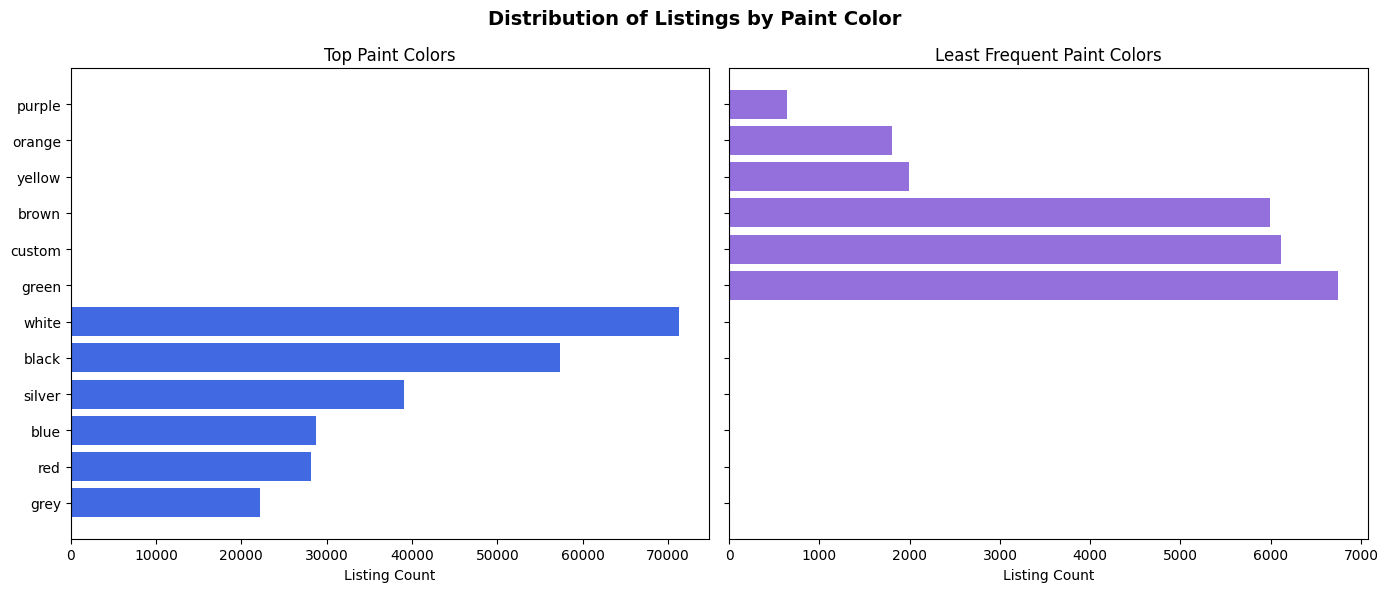

top 6 paint_colors:
              count      mean   min     max    median
paint_color                                         
white        71292 22,969.19  1500  159991 19,999.00
black        57336 22,260.01  1500  169999 18,998.00
silver       39083 17,188.45  1500  167500 13,950.00
blue         28695 17,584.81  1500  169888 14,000.00
red          28194 19,881.24  1500  149000 16,900.00
grey         22127 16,177.97  1500  155000 11,995.00
bottom 6 paint_color:
              count      mean   min     max    median
paint_color                                         
green         6741 13,632.53  1500  158000  9,200.00
custom        6116 16,826.63  1500  150000 13,000.00
brown         5998 16,658.63  1500  118500 12,900.00
yellow        1993 19,359.48  1500  169999 15,000.00
orange        1805 19,896.98  1500  152995 18,652.00
purple         637 16,147.96  1500  165000 10,988.00


In [101]:
#Paint_color Analysis

# 🎨 Count of listings by paint color
color_counts = car_df['paint_color'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Top 6 paint colors
top_colors = color_counts.head(6)
axes[0].barh(top_colors.index[::-1], top_colors.values[::-1], color='royalblue')
axes[0].set_title("Top Paint Colors")
axes[0].set_xlabel("Listing Count")

# Bottom 6 paint colors
bottom_colors = color_counts.tail(6)
axes[1].barh(bottom_colors.index, bottom_colors.values, color='mediumpurple')
axes[1].set_title("Least Frequent Paint Colors")
axes[1].set_xlabel("Listing Count")

fig.suptitle("Distribution of Listings by Paint Color", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Top and bottom paint colors by volume.png", dpi=300, bbox_inches='tight')
plt.show()

# Group by paint_color and get basic price stats
paint_color_price_stats = (
    car_df.groupby('paint_color')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='count', ascending=False)
)

# Display top and bottom 6 with price info
top10_price = paint_color_price_stats.head(6)
print("top 6 paint_colors:\n", top10_price)
bottom10_price = paint_color_price_stats.tail(6)
print("bottom 6 paint_color:\n", bottom10_price)

## 🎨 Feature Review: `paint_color` — Decision & Summary

After evaluating the `paint_color` feature, we found that while some colors like **white**, **black**, and **silver** dominate in frequency, and others like **purple**, **orange**, and **yellow** are far less common, the overall price variation across colors is minimal and inconsistent.

- Common colors include: white, black, silver, blue, red, grey, green, and brown.
- Rare or niche colors include: custom, yellow, orange, and purple.
- These trends are more aesthetically interesting than statistically impactful.

### ✅ Decision

We are choosing to **drop `paint_color` from the modeling pipeline**, as it provides limited predictive value and unnecessarily increases categorical complexity.

### 🕵️ For Future Reference

The color insights—e.g., "white is the most common", "purple is among the rarest"—may still be valuable for UI, personalization, or marketing use cases, and the column can be reintroduced if modeling vehicle appearance becomes relevant.

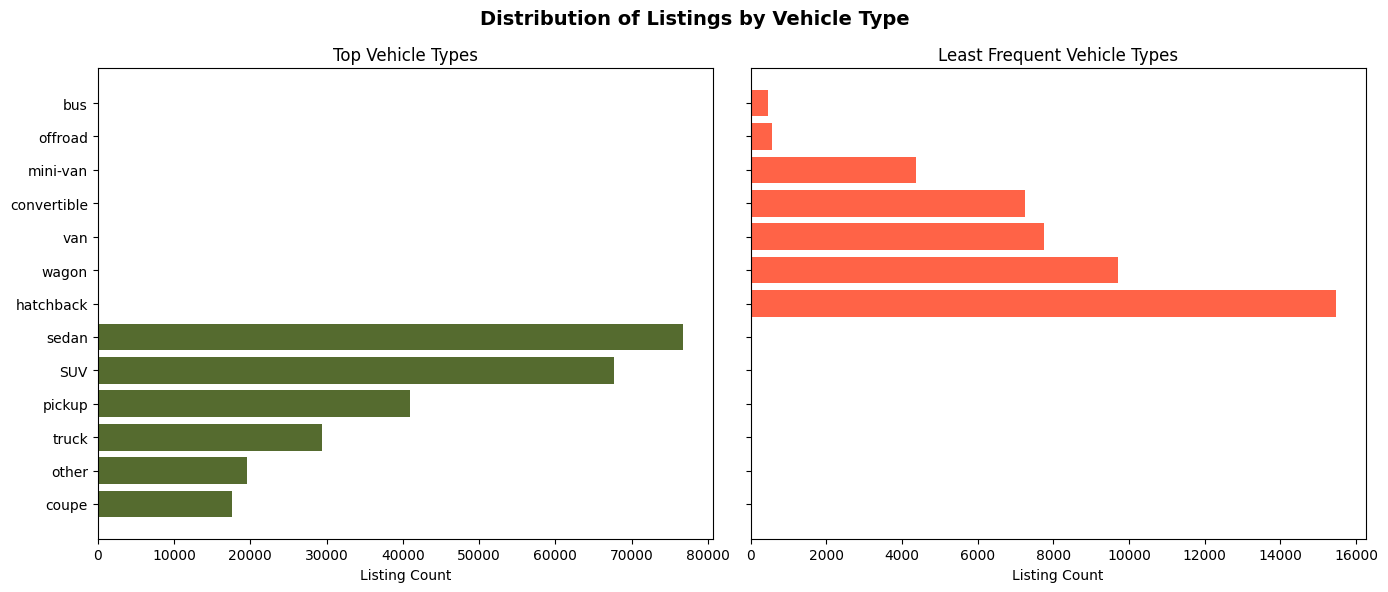

top 6 types:
         count      mean   min     max    median
type                                           
sedan   76798 14,767.66  1500  156900 11,900.00
SUV     67701 18,284.44  1500  155000 15,000.00
pickup  40986 28,912.87  1500  135900 28,590.00
truck   29393 28,121.16  1500  167500 25,995.00
other   19572 27,895.90  1500  169950 27,990.00
coupe   17565 23,431.17  1500  169999 20,590.00
bottom 7 types:
              count      mean   min     max    median
type                                                
hatchback    15479 15,411.40  1500   98995 14,990.00
wagon         9710 14,624.58  1500  159995 12,999.00
van           7755 19,223.70  1500  160000 16,990.00
convertible   7248 20,923.06  1500  159991 16,000.00
mini-van      4381 10,139.00  1500   79900  7,800.00
offroad        573 16,783.29  1500   95000 13,000.00
bus            456 15,951.20  1500  125000 12,900.00


In [102]:
# type (Vehicle Type) Analysis

# 🚗 Count listings by vehicle type
type_counts = car_df['type'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Top 6 types
top_types = type_counts.head(6)
axes[0].barh(top_types.index[::-1], top_types.values[::-1], color='darkolivegreen')
axes[0].set_title("Top Vehicle Types")
axes[0].set_xlabel("Listing Count")

# Bottom 7 types
bottom_types = type_counts.tail(7)
axes[1].barh(bottom_types.index, bottom_types.values, color='tomato')
axes[1].set_title("Least Frequent Vehicle Types")
axes[1].set_xlabel("Listing Count")

fig.suptitle("Distribution of Listings by Vehicle Type", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("images/Top and bottom types by volume.png", dpi=300, bbox_inches='tight')
plt.show()

# Group by type and get basic price stats
type_price_stats = (
    car_df.groupby('type')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='count', ascending=False)
)

# Display top and bottom with price info
top10_price = type_price_stats.head(6)
print("top 6 types:\n", top10_price)
bottom10_price = type_price_stats.tail(7)
print("bottom 7 types:\n", bottom10_price)

## 🚘 Feature Review: `type` — Decision & Summary

---

### 📊 Overview

The `type` feature provides categorical labels for vehicle form factors such as **sedan**, **SUV**, **pickup**, **truck**, **coupe**, **van**, etc. It exhibits a strong alignment with price tiers and market positioning.

- Common vehicle types include: sedan, SUV, pickup, truck, and coupe.
- Less frequent types include: wagon, hatchback, mini-van, convertible, offroad, and bus.
- Despite varied frequency, all categories display stable pricing and meaningful segmentation.

---

### ✅ Modeling Decision

We are choosing to **retain `type` as a key categorical feature** in the model.

- It offers **clear stratification of vehicle value**, distinguishing passenger cars from utility vehicles, luxury variants, and commercial transports.
- `type` is **clean and low in cardinality**, making it highly interpretable and modeling-friendly.
- Replaces more granular fields like `model` and partially captures signals that would otherwise require complex normalization.

---

### 🕵️ For Future Reference

If future modeling demands additional depth:

- Explore **type-based residuals** (e.g. vehicle-level deviation from average type price).
- Create **interaction features**, such as `type × fuel_type` or `type × region_price_residual`.
- Investigate **region-type popularity trends** to enrich geographic profiling.

---

### ✨ Summary

- ✅ Retain `type` as a reliable, generalizable predictor of vehicle price  
- 🚫 No cleanup or reduction required; distribution is robust across segments  
- 📌 Consider as a foundation for future interaction terms if deeper behavioral modeling is pursued

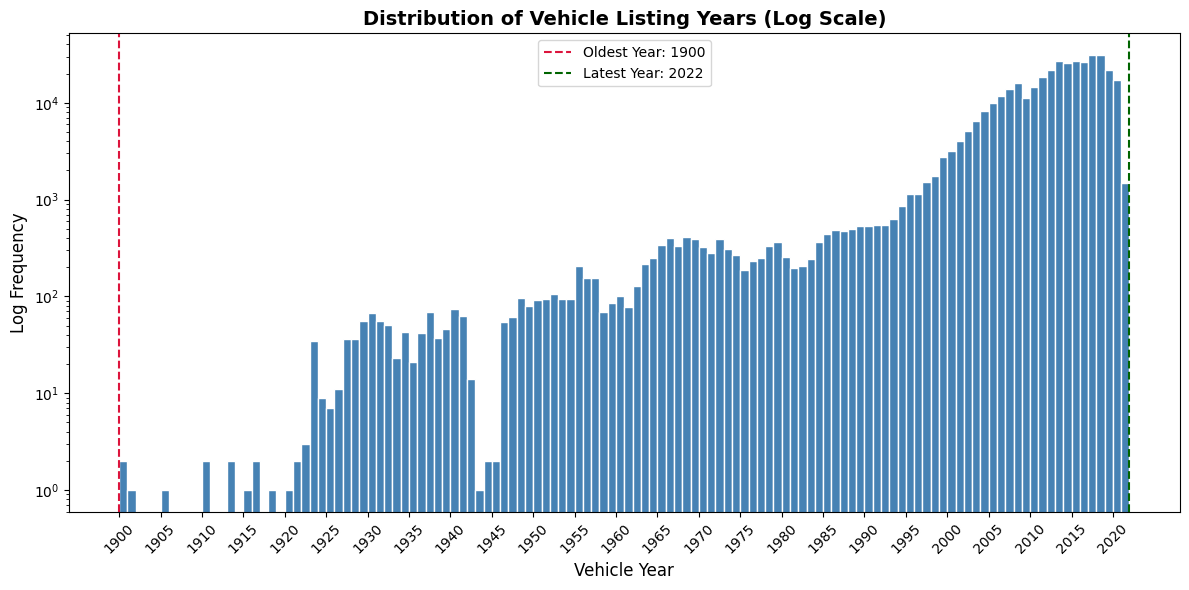

top 10 volumes by year :
              count      mean   min     max    median
type                                                
sedan        76798 14,767.66  1500  156900 11,900.00
SUV          67701 18,284.44  1500  155000 15,000.00
pickup       40986 28,912.87  1500  135900 28,590.00
truck        29393 28,121.16  1500  167500 25,995.00
other        19572 27,895.90  1500  169950 27,990.00
coupe        17565 23,431.17  1500  169999 20,590.00
hatchback    15479 15,411.40  1500   98995 14,990.00
wagon         9710 14,624.58  1500  159995 12,999.00
van           7755 19,223.70  1500  160000 16,990.00
convertible   7248 20,923.06  1500  159991 16,000.00
bottom 10 volumes by year:
              count      mean   min     max    median
type                                                
truck        29393 28,121.16  1500  167500 25,995.00
other        19572 27,895.90  1500  169950 27,990.00
coupe        17565 23,431.17  1500  169999 20,590.00
hatchback    15479 15,411.40  1500   98995 14

In [103]:
# Drop NaNs temporarily for plotting
year_data = car_df['year'].dropna()

plt.figure(figsize=(12, 6))
plt.hist(year_data, bins=np.arange(year_data.min(), year_data.max() + 1), 
         color='steelblue', edgecolor='white')
plt.yscale('log')

# Highlight oldest and latest year
plt.axvline(year_data.min(), color='crimson', linestyle='--', linewidth=1.5,
            label=f"Oldest Year: {int(year_data.min())}")
plt.axvline(year_data.max(), color='darkgreen', linestyle='--', linewidth=1.5,
            label=f"Latest Year: {int(year_data.max())}")

# Axis labels and ticks
plt.xlabel("Vehicle Year", fontsize=12)
plt.ylabel("Log Frequency", fontsize=12)
plt.title("Distribution of Vehicle Listing Years (Log Scale)", fontsize=14, fontweight='bold')

xticks = np.arange(year_data.min(), year_data.max() + 1, 5)
plt.xticks(xticks, rotation=45)

plt.legend()
plt.tight_layout()
plt.savefig("images/Distribution of Vehicle listing on years with frequency log scale.png", dpi=300, bbox_inches='tight')
plt.show()

# Group by year and get basic price stats
year_price_stats = (
    car_df.groupby('year')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='count', ascending=False)
)

# Display top and bottom with price info
top10_price = type_price_stats.head(10)
print("top 10 volumes by year :\n", top10_price)
bottom10_price = type_price_stats.tail(10)
print("bottom 10 volumes by year:\n", bottom10_price)


### ✨ Summary

- ✅ Highest-volume years (2013–2018) offer strong statistical grounding for modeling  
- 📈 2020 shows a sharp price uptick despite lower count — possibly higher-end inventory  
- ⚠️ Sparse entries pre-1945 introduce noise; flag for filtering or exclusion if inconsistent with modeling goals


In [104]:
# 🎯 Define modeling range: Keep cars from 1945 to 2024
vintage_car_df = car_df[car_df['year'] < 1946]
print(f'🔍 Pre-1946 cars identified: {vintage_car_df.shape[0]}')
vintage_car_df.to_csv("data/vintage_car data.csv, index=False")

# Drop all cars outside the target year range
car_df = car_df[(car_df['year'] >= 1945) & (car_df['year'] <= 2024)]
print(f'✅ Size after year filter: {car_df.shape[0]:_}')

🔍 Pre-1946 cars identified: 820
✅ Size after year filter: 375_682


In [105]:
car_df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

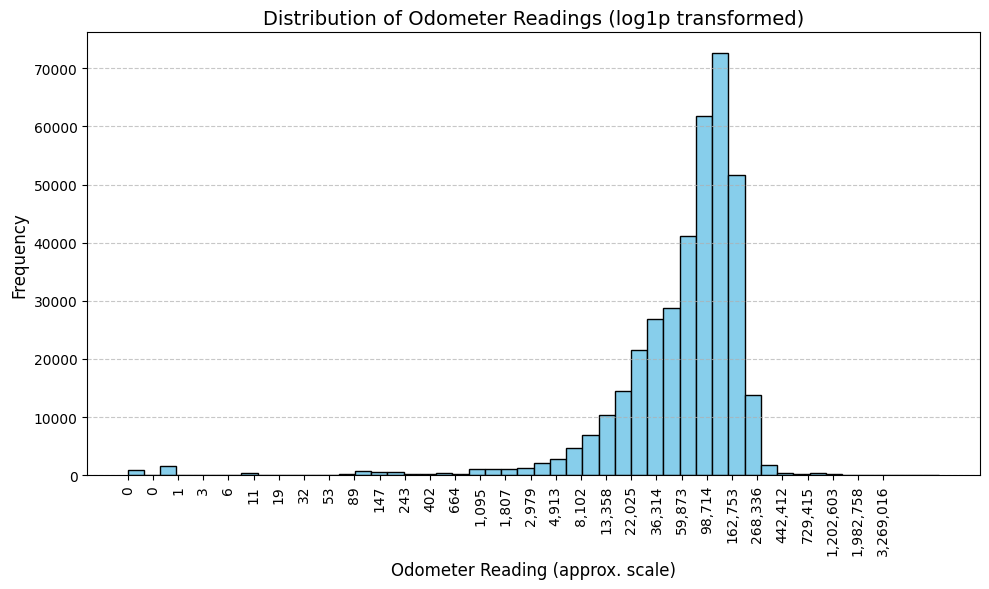

top 10 price by odomoeter reading :
            count       mean     min     max     median
odometer                                              
6,899.00       1 169,999.00  169999  169999 169,999.00
6,318.00      13 163,540.00  163540  163540 163,540.00
10,325.00      1 162,995.00  162995  162995 162,995.00
599.00         1 159,995.00  159995  159995 159,995.00
631.00         1 158,000.00  158000  158000 158,000.00
5,434.00       1 154,950.00  154950  154950 154,950.00
8,301.00       1 154,950.00  154950  154950 154,950.00
5,783.00       1 154,585.00  154585  154585 154,585.00
6,070.00       1 152,995.00  152995  152995 152,995.00
16,026.00      1 150,000.00  150000  150000 150,000.00
bottom 10 price by odometer reading :
             count     mean   min   max   median
odometer                                       
49,142.00       1 1,500.00  1500  1500 1,500.00
42,515.00       1 1,500.00  1500  1500 1,500.00
221,385.00      1 1,500.00  1500  1500 1,500.00
78,989.00       1 1,500.

In [106]:
# 📊 Histogram of log-transformed odometer readings
log1p_odometer = np.log1p(car_df['odometer'])
plt.figure(figsize=(10, 6))
plt.hist(log1p_odometer, bins=50, color='skyblue', edgecolor='black')

# 🏷️ Axis labels with original scale ticks
plt.xlabel('Odometer Reading (approx. scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Custom tick formatting for better interpretability
tick_vals = np.arange(0, 15.5, 0.5)
tick_labels = [f"{int(np.expm1(val)):,}" for val in tick_vals]
plt.xticks(tick_vals, tick_labels, rotation=90)

# 🧭 Title and styling
plt.title('Distribution of Odometer Readings (log1p transformed)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/Distribution of Odometer Readings (log1p transformed).png", dpi=300, bbox_inches='tight')
plt.show()

# Group by odometer reading and get basic price stats
odometer_price_stats = (
    car_df.groupby('odometer')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='mean', ascending=False)
)

# Display top and bottom with price info
top10_price = odometer_price_stats.head(10)
print("top 10 price by odomoeter reading :\n", top10_price)
bottom10_price = odometer_price_stats.tail(10)
print("bottom 10 price by odometer reading :\n", bottom10_price)



## 🚗 Odometer Extremes — Price Segmentation Insights

---

### 💎 Top 10 Highest-Priced Vehicles by Odometer Reading

- **6,899 km** — 169,999, single entry at premium tier  
- **6,318 km** — 13 entries, average 163,540, all at exact value — possible flagship model cluster  
- **10,325 km** — 162,995, luxury low-use vehicle  
- **631 km** — 158,000,  minimal usage, likely showroom or recent model
- **599 km** — 159,995, near-new price territory  
- **5,434 km & 8,301 km** — both at 154,950, premium but slightly higher wear  
- **5,783 km** — 154,585  
- **6,070 km** — 152,995  
- **16,026 km** — 150,000

📌 These vehicles appear to reside in **luxury/super-premium strata**, with odometer values well below fleet norms and minimal variation in price — suggesting possible performance or collector categories.

---

### 🪙 Bottom 10 Lowest-Priced Vehicles by Odometer Reading

- **49,142 km to 221,385 km** — All priced at $1,500 despite huge mileage range  
- **Common traits**: Each odometer point is a singleton, all priced at floor value ($1,500)  
- **Notable high-mileage entries**: 221,385 km, 221,100 km, 220,638 km — likely very old or distressed units  

📌 These form the **lower-bound pricing floor**—potential data noise, salvage vehicles, or auction-level inventory. Heavy outlier mileage may impact model skew.

---

### 🔍 Analytical Deductions

- Odometer and price exhibit **clear non-linear relationships** — high price clusters center around **very low usage**, while price collapses at **extreme mileage** regardless of variation.
- This validates use of **`log1p(odometer)`**, as it compresses mileage spread while preserving differentiability in lower tiers.

---

## 🛠️ Odometer-Based Price Segmentation — Immediate Actions & Future Enhancements

---

### ✅ What to Do Right Now

high-priority steps to strengthen the model with minimal overhead:

- **Use `log1p(odometer)`** as the main mileage feature — it normalizes skew and improves predictive stability.
- **Drop or tag vehicles with odometer > 300,000 km or < 1,000 km** — these extreme cases either reflect salvage-level usage or showroom/demo stock and can distort learning.
- **Retain vehicles priced between ~$1,500 and ~$170,000** but **flag ultra-low-price clusters** (e.g. $1,500 with 200,000+ km) as potential data quality artifacts or distinct class.
- **Keep `log_odometer` unbinned** for now, preserving nuance for regression models and avoiding premature discretization.
- **Validate `log_odometer` correlation with current model residuals** to check its explanatory power.
- Tag low-mileage luxury bins for potential **segmented modeling** or separate resale valuation : manual sale price fixation for now. May be modelled separately later, if effort is available.  

---

### 💡 For Another Day (Optional, If Intricate Modeling Is Needed)

when resources allow for deeper preprocessing or advanced feature engineering:

- Create an **odometer-based usage band feature**, e.g. `mileage_group = low / med / high`, to support interaction terms.
- Engineer `odometer_per_year` or `km_per_age` to model relative wear by age, especially useful for comparing older vehicles.
- Train segmented models for **low-mileage luxury vehicles** vs. **high-mileage economy segments**, as pricing behavior diverges strongly across these strata.
- Explore joint interaction features like `log_odometer × fuel_type`, `log_odometer × type`, or `log_odometer × region_price_residual` for behavioral modeling.
- Evaluate whether floor-price vehicles represent **true market behavior** or **data quality artifacts**
---

### 🧭 Summary

Start with **log-transforming mileage**, drop outliers conservatively, and assess how well the cleaned feature explains price. Down the line, tap into odometer dynamics for richer buyer profiling or usage-condition inference.


In [107]:
# 🎯 Capture and drop extreme odometer values for separate analysis
# Thresholds: <1,000 km (suspiciously low) or >300,000 km (possible wear-out phase)

car_low_run_or_defective_data = car_df[(car_df['odometer'] < 1000) | (car_df['odometer'] > 300_000)]
print(f'🚫 Vehicles flagged and removed due to extreme odometer readings: {car_low_run_or_defective_data.shape[0]}')
car_low_run_or_defective_data.to_csv("data/car_low_run_or_defective_data.csv", index=False)

car_df.drop(car_low_run_or_defective_data.index, inplace=True)
print(f'✅ Dataset size after odometer outlier removal: {car_df.shape[0]:_}')

🚫 Vehicles flagged and removed due to extreme odometer readings: 9386
✅ Dataset size after odometer outlier removal: 366_296


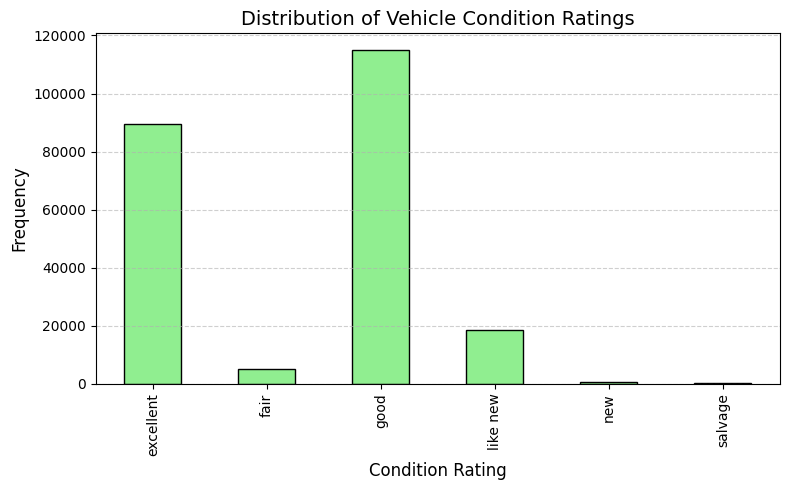

Condition tiers by price:
             count      mean   min     max    median
condition                                          
new           647 24,961.28  1900  149000 17,800.00
good       114995 21,230.12  1500  150000 20,990.00
like new    18621 19,859.02  1500  169888 15,000.00
excellent   89562 15,812.05  1500  169999 11,999.00
salvage       327  5,746.60  1500   35989  3,800.00
fair         4946  4,583.63  1500  123456  3,450.00


In [108]:
# 📊 Visualize the distribution of vehicle condition
plt.figure(figsize=(8, 5))
car_df['condition'].value_counts().sort_index().plot(
    kind='bar', color='lightgreen', edgecolor='black'
)
plt.xlabel('Condition Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Vehicle Condition Ratings', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("images/Distribution of Vehicle Condition Ratings.png", dpi=300, bbox_inches='tight')
plt.show()

# 🧮 Price statistics grouped by condition rating
condition_price_stats = (
    car_df.groupby('condition')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='mean', ascending=False)
)

# 🔝 Condition categories by average price
conditions = condition_price_stats.head(6)
print("Condition tiers by price:\n", conditions)


## 🛠️ Vehicle Condition Analysis — Insights, Immediate Actions & Future Enhancements

---

### 🔍 Analytical Insights

- `condition` is a **clean, low-cardinality categorical feature** with intuitive value hierarchy.
- There’s a **clear, monotonic price gradient**: `new` → `good` → `like new` → `excellent` → `salvage` → `fair`.
- Vehicles labeled `new` have the highest mean price (~$24.9k), but their median (~$17.8k) suggests wide pricing dispersion — possibly reflecting variance in brand, segment, or listing quality.
- Surprisingly, `excellent` trails behind `like new` and `good`, potentially due to inconsistent labeling practices by sellers or platform-specific criteria.
- The `salvage` and `fair` categories form a **distinct low-price cluster** — mean prices ~$5.7k and ~$4.6k respectively — signaling structural damage or very poor condition.

---

### ✅ What to Do Right Now

These steps are quick to implement and beneficial for modeling quality:

- **Retain `condition` as-is** — the feature is clean, interpretable, and models pricing tiers effectively.
- **Ordinal encode `condition`** based on pricing hierarchy:
  - Suggested mapping:  
    `fair = 0`, `salvage = 1`, `excellent = 2`, `like new = 3`, `good = 4`, `new = 5`
- **Validate whether `condition` is additive in regression models**, or better captured via one-hot encoding in tree-based methods.
- **Flag listings with `salvage` and `fair`** as candidates for separate modeling or floor-price stabilization.

---

### 💡 For Another Day (Optional, If Modeling Effort Permits)

If deeper preprocessing and modeling effort is available:

- Create **interaction terms**: `condition × odometer`, `condition × year`, and `condition × fuel_type` — these may capture hidden variation in how condition interacts with usage or vehicle age.
- Investigate **price spread within each condition tier** to detect label leakage or mixed inventory pools.
- Explore **text mining listing descriptions** (if available) to cross-verify or refine `condition` labels using NLP.
- Build a **binary flag like `is_premium_condition`** (`new`, `like new`, `good`) vs. others to help simplify business rule logic in downstream applications.
- Use `condition` to **adjust residual analysis** — vehicles marked "excellent" but priced below group average may reflect distressed assets or misclassification.

---

### 🧭 Summary

The `condition` feature provides meaningful segmentation for price modeling. Treat it as a reliable categorical input now, while keeping an eye on misclassifications and interaction effects in future iterations. Ground it in logic today, and dig deeper into behavioral patterns later.

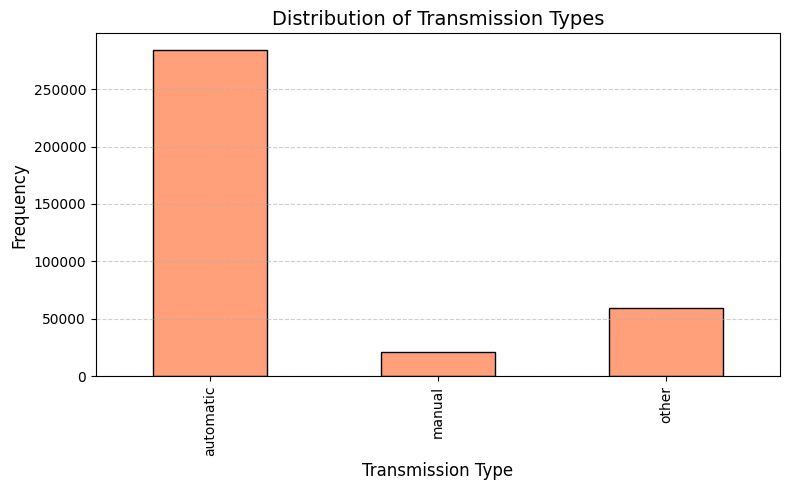

Transmission types by price:
                count      mean   min     max    median
transmission                                          
other          59367 28,392.23  1500  150000 28,590.00
automatic     284379 17,954.52  1500  169999 13,829.00
manual         20867 15,143.90  1500  154999 10,000.00


In [109]:
# 📊 Bar plot of transmission distribution
plt.figure(figsize=(8, 5))
car_df['transmission'].value_counts().sort_index().plot(
    kind='bar', color='lightsalmon', edgecolor='black'
)
plt.xlabel('Transmission Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Transmission Types', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("images/Distribution of Transmission Types.png", dpi=300, bbox_inches='tight')
plt.show()

# 🧮 Price statistics grouped by transmission type
transmission_price_stats = (
    car_df.groupby('transmission')['price']
    .agg(['count', 'mean', 'min', 'max', 'median'])
    .sort_values(by='mean', ascending=False)
)

# 🔝 Transmission types by average price
transmissions = transmission_price_stats.head()
print("Transmission types by price:\n", transmissions)


In [110]:
car_df.isna().mean()



id             0.00
region         0.00
price          0.00
year           0.00
manufacturer   0.03
model          0.01
condition      0.37
cylinders      0.41
fuel           0.01
odometer       0.01
title_status   0.02
transmission   0.00
VIN            0.38
drive          0.30
size           0.72
type           0.21
paint_color    0.28
state          0.00
dtype: float64

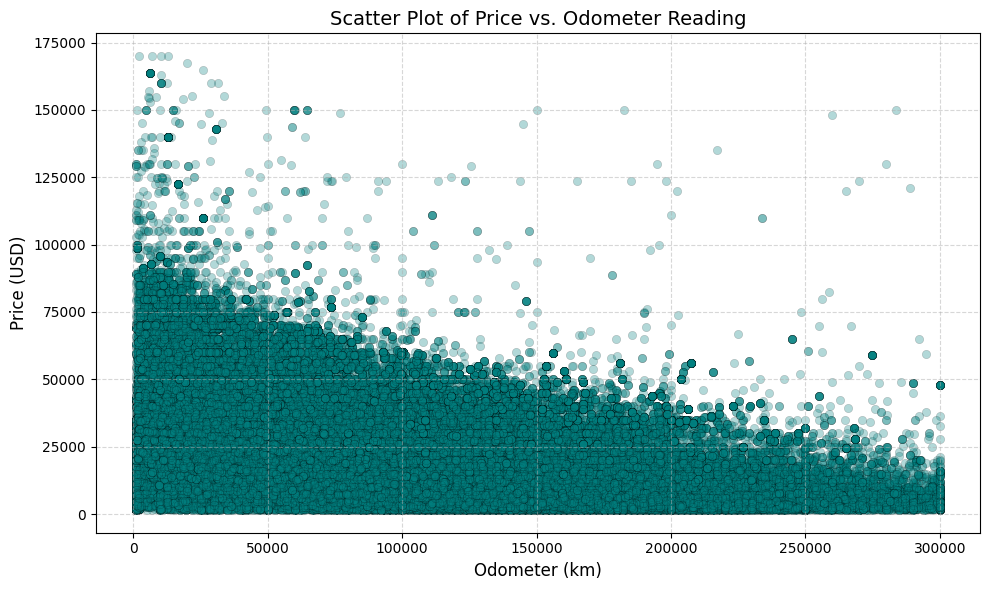

In [111]:
plt.figure(figsize=(10, 6))
plt.scatter(
    car_df['odometer'], car_df['price'],
    alpha=0.3, edgecolors='k', linewidths=0.3, color='teal'
)

plt.xlabel('Odometer (km)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.title('Scatter Plot of Price vs. Odometer Reading', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("images/Scatter Plot of Price vs. Odometer Reading.png", dpi=300, bbox_inches='tight')
plt.show()


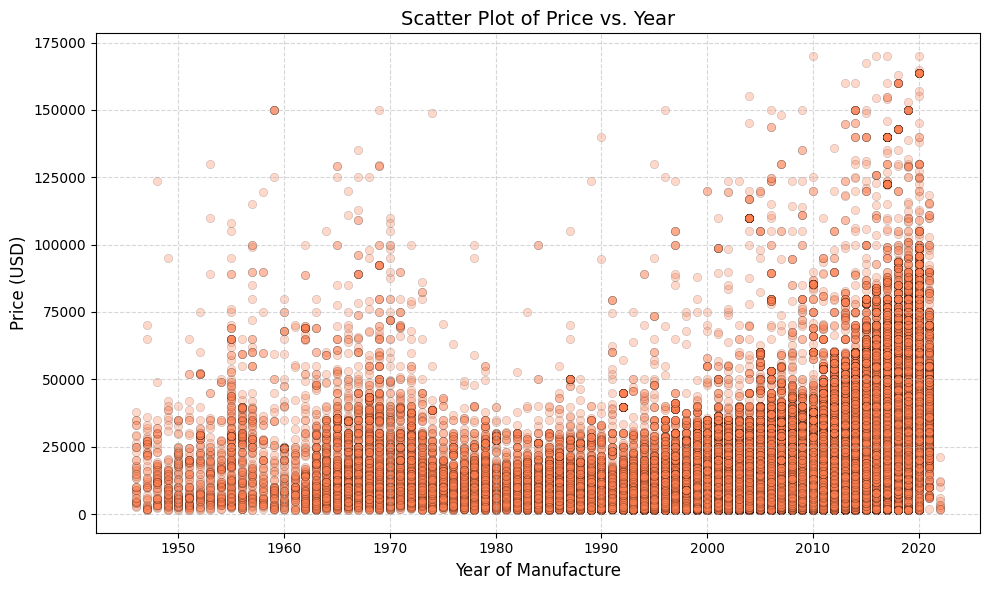

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(
    car_df['year'], car_df['price'],
    alpha=0.3, color='coral', edgecolors='k', linewidths=0.3
)

plt.xlabel('Year of Manufacture', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.title('Scatter Plot of Price vs. Year', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("images/Scatter Plot of Price vs. Year.png", dpi=300, bbox_inches='tight')
plt.show()

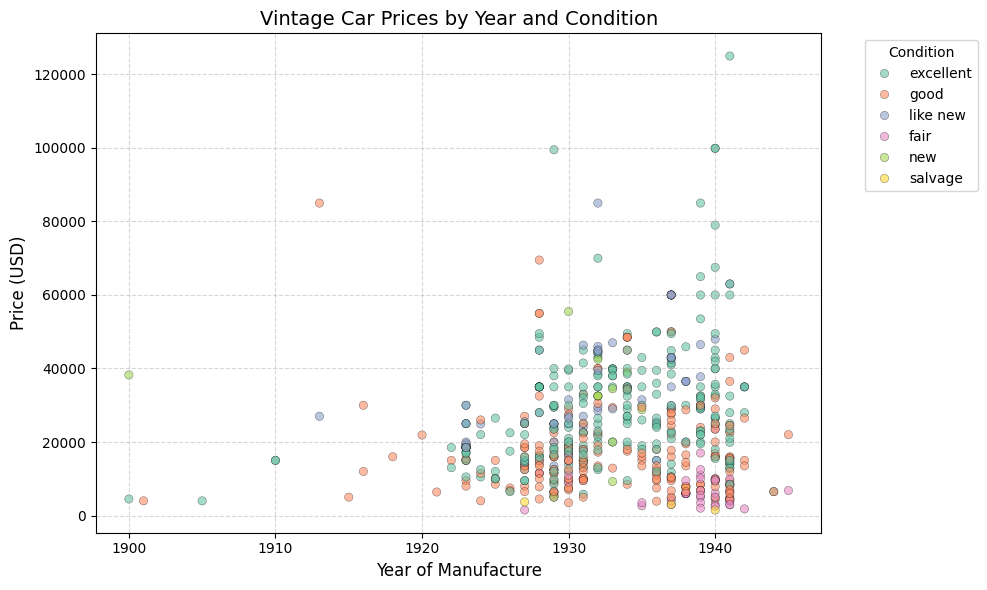

In [113]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='year',
    y='price',
    hue='condition',
    data=vintage_car_df,
    palette='Set2',
    alpha=0.6,
    edgecolor='k',
    linewidth=0.3
)

plt.title('Vintage Car Prices by Year and Condition', fontsize=14)
plt.xlabel('Year of Manufacture', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("images/Vintage Car Prices by Year and Condition.png", dpi=300, bbox_inches='tight')
plt.show()

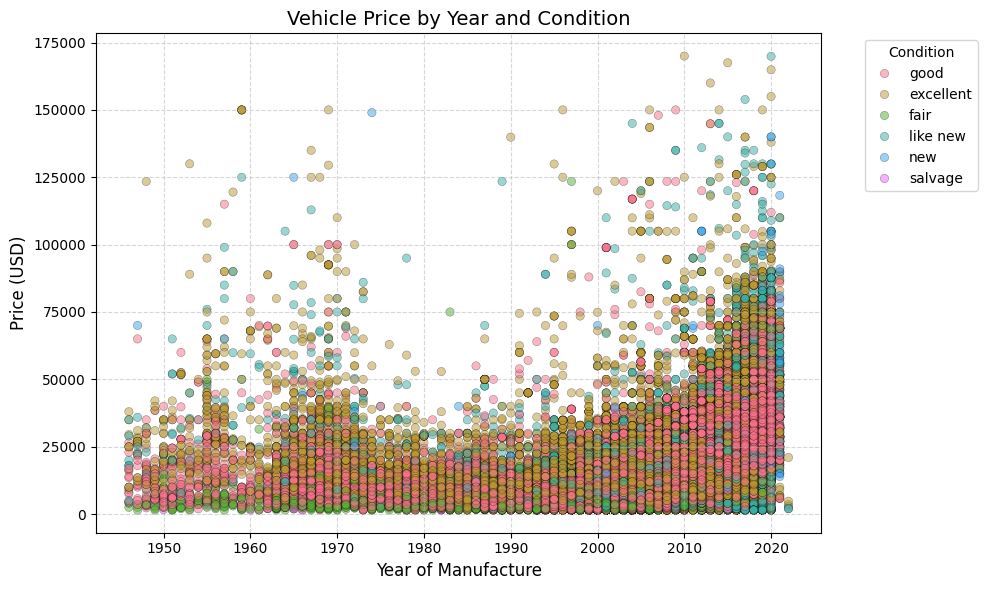

In [114]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='year',
    y='price',
    hue='condition',
    data=car_df,
    palette='husl',
    alpha=0.5,
    edgecolor='black',
    linewidth=0.3
)

plt.xlabel('Year of Manufacture', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.title('Vehicle Price by Year and Condition', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("images/Vehicle Price by Year and Condition.png", dpi=300, bbox_inches='tight')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [115]:
# 🔻 Step 1: Drop unnecessary or high-cardinality columns
columns_to_drop = ['id', 'VIN', 'region', 'state', 'model', 'manufacturer', 'size', 'paint_color']
car_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 🔢 Step 2: Fill numeric missing values with medians
car_df['year'] = car_df['year'].fillna(car_df['year'].median())
car_df['odometer'] = car_df['odometer'].fillna(car_df['odometer'].median())

# 🧽 Step 3: Fill categorical missing values with mode
cat_cols_final = [
    'condition', 'cylinders', 'fuel', 'title_status',
    'transmission', 'drive', 'type'
]

for col in cat_cols_final:
    mode_val = car_df[col].mode()[0]
    print(f"{col}_mode: {mode_val}")
    car_df[col] = car_df[col].fillna(mode_val)

# 🔍 Step 4: Scan for remaining missingness
print("🔎 Remaining missing value ratio by column:")
print(car_df.isna().mean().sort_values(ascending=False))

condition_mode: good
cylinders_mode: 6 cylinders
fuel_mode: gas
title_status_mode: clean
transmission_mode: automatic
drive_mode: 4wd
type_mode: sedan
🔎 Remaining missing value ratio by column:
price          0.00
year           0.00
condition      0.00
cylinders      0.00
fuel           0.00
odometer       0.00
title_status   0.00
transmission   0.00
drive          0.00
type           0.00
dtype: float64


In [116]:
# Replace 'year' with 'vehicle_age' and cast as integer
CURRENT_YEAR = datetime.now().year
car_df['vehicle_age'] = (CURRENT_YEAR - car_df['year']).astype(int)
car_df.drop(columns='year', inplace=True)

# Sanity check on age distribution
print(car_df['vehicle_age'].describe())

count   366,296.00
mean         13.66
std           8.52
min           3.00
25%           8.00
50%          12.00
75%          17.00
max          79.00
Name: vehicle_age, dtype: float64


In [117]:
zero_rows = car_df[(car_df['odometer'] == 0) | (car_df['price'] == 0)]
print(f"🔍 Rows with zero odometer or zero price: {zero_rows.shape[0]}")

# Optional: inspect a few of them
zero_rows.head()

🔍 Rows with zero odometer or zero price: 0


,price,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,vehicle_age


In [118]:
# ✅ Already computed earlier. But again computed to avoid any errorneous allocation later and drop odometer column. 
car_df['log1p_odometer'] = np.log1p(car_df['odometer'])
car_df.drop('odometer', inplace=True, axis=1)

# 🚫 No need to log-transform vehicle age; it's interpretable and linearly useful
# So we skip: car_df['car_age'] = np.log(car_df['car_age'])

# 💰 log1p-transform target variable (price) for regression stability: though no zero entries but model should be stable for future zero entries
car_df['log1p_price'] = np.log1p(car_df['price'])

In [119]:
# Save the car_df DataFrame to a CSV file in the Colab environment
car_df.to_csv('data/car_data_refined(one_pass)_ready_for modelling.csv', index=False)
print("DataFrame saved to 'car_data_preprocessed_first_refine.csv")

DataFrame saved to 'car_data_preprocessed_first_refine.csv


In [64]:
car_df.isna().mean()

price            0.00
condition        0.00
cylinders        0.00
fuel             0.00
title_status     0.00
transmission     0.00
drive            0.00
type             0.00
vehicle_age      0.00
log1p_odometer   0.00
log1p_price      0.00
dtype: float64

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [65]:
# 🎯 Define feature matrix X and target vector y (log1p scale)
X = car_df.drop(columns=['price', 'log1p_price'], errors='ignore')
y = car_df['log1p_price']  # or use 'log_price' if modeling on log scale

# 🔁 Alternate NOT used here: switch target for regression on log-transformed price
# y = car_df['price']

In [66]:
# 📦 Train–test split (80/20 with reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 🔍 Sanity check
print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Test set:     {X_test.shape[0]:,} rows")

Training set: 293,036 rows
Test set:     73,260 rows


In [67]:
# ✅ Numerical features — use log-transformed odometer + vehicle age
num_features = ['vehicle_age', 'log1p_odometer']

num_transformer = make_pipeline(
    FunctionTransformer(validate=False, feature_names_out='one-to-one'),
    MinMaxScaler()
)

# ✅ Ordinal categorical features and their orderings
ordinal_features = [
    'condition', 'cylinders', 'fuel',
    'title_status', 'transmission', 'drive', 'type'
]

ordinal_categories = [
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],  # condition
    ['3 cylinders', '4 cylinders', 'other', '5 cylinders', '6 cylinders', '8 cylinders',
     '10 cylinders', '12 cylinders'],  # cylinders
    ['gas', 'other', 'hybrid', 'diesel', 'electric'],  # fuel
    ['parts only', 'salvage', 'missing', 'rebuilt', 'lien', 'clean'],  # title_status
    ['manual', 'other', 'automatic'],  # transmission
    ['fwd', 'rwd', '4wd'],  # drive
    ['sedan', 'pickup', 'other', 'van', 'SUV', 'truck', 'hatchback',
     'coupe', 'wagon', 'convertible', 'mini-van', 'bus', 'offroad']  # type
]

ordinal_transformer = OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)

# ✅ Combine all preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('ordinal', ordinal_transformer, ordinal_features)
])
    


In [68]:
X_train.columns

Index(['condition', 'cylinders', 'fuel', 'title_status', 'transmission',
       'drive', 'type', 'vehicle_age', 'log1p_odometer'],
      dtype='object')

In [69]:
# Code block that may eb used for outliers in separate analysis 

# 🧠 Step 1: Define models and their hyperparameter grids
models = {
    'Linear': (
        LinearRegression(), 
        {}
    ),
    'Ridge': (
        Ridge(), 
        {'model__alpha': [0.1, 1.0, 10.0]}
    ),
    'Lasso': (
        Lasso(max_iter=10_000), 
        {'model__alpha': [0.001, 0.01, 0.1]}
    ),
    'RandomForest': (
        RandomForestRegressor(random_state=42), 
        {
            'model__n_estimators': [25, 50], # use 50,100 for max accuracy when compute is available 
            'model__max_depth': [10, 10] #Use None for max accuracy when compute is available
        }
    )
}

# 🧪 Step 2: Wrap each model in a preprocessing pipeline and a GridSearchCV
pipelines = {}
for name, (estimator, grid) in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    grid_search = GridSearchCV(
        pipe,
        param_grid=grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    pipelines[name] = grid_search
     

In [70]:
#Code block may be re-used for outliers 

def evaluate_model(name, grid, X_train, y_train, X_test, y_test):
    print(f"Training {name}...")
    grid.fit(X_train, y_train)
    
    model = grid.best_estimator_
    y_pred = model.predict(X_test)
    
    return {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'Best Params': grid.best_params_
    }

results = {
    name: evaluate_model(name, grid, X_train, y_train, X_test, y_test)
    for name, grid in pipelines.items()
}

results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
print(results_df)




Training Linear...
Training Ridge...
Training Lasso...
Training RandomForest...
             RMSE   R2                                        Best Params
RandomForest 0.41 0.75  {'model__max_depth': 10, 'model__n_estimators'...
Ridge        0.55 0.56                              {'model__alpha': 0.1}
Linear       0.55 0.56                                                 {}
Lasso        0.55 0.56                            {'model__alpha': 0.001}


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [71]:
# Relative importance of features as per RF model(with shallow depth)
result = permutation_importance(
    pipelines['RandomForest'].best_estimator_, 
    X_test, y_test, 
    n_repeats=6, random_state=42 # use 10 when compute is available 
)

#Using RF
importances = result.importances_mean
#feature_names = pipelines['RandomForest'].best_estimator_.named_steps['preprocessor'].get_feature_names_out()
feature_names = X_test.columns

sorted_feats = sorted(zip(feature_names, importances), key=lambda x: -x[1])
for feat, score in sorted_feats[:10]:
    print(f"{feat}: {score:.4f}")

vehicle_age: 0.5942
log1p_odometer: 0.2135
cylinders: 0.1162
fuel: 0.0937
drive: 0.0600
type: 0.0515
condition: 0.0162
title_status: 0.0057
transmission: 0.0044


In [73]:
#Relative importance of features as per Linear model

#If Linear is close to RF and is  used

result_linear = permutation_importance(
    pipelines['Linear'].best_estimator_, 
    X_test, y_test, 
    n_repeats=6, random_state=42
)
importances_linear = result_linear.importances_mean
#feature_names = pipelines['RandomForest'].best_estimator_.named_steps['preprocessor'].get_feature_names_out()
feature_names = X_test.columns

sorted_feats = sorted(zip(feature_names, importances_linear), key=lambda x: -x[1])
for feat, score in sorted_feats[:10]:
    print(f"{feat}: {score:.4f}")



log1p_odometer: 0.3867
vehicle_age: 0.2142
fuel: 0.0871
cylinders: 0.0744
drive: 0.0533
title_status: 0.0097
type: 0.0070
condition: 0.0058
transmission: 0.0008


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# 🚘 Executive Summary: Pre-Owned Vehicle Price Insights

This summary provides a high-level view of key pricing drivers, data patterns, and strategic implications uncovered during the vehicle pricing analysis. It prioritizes simplicity, clarity, and direct business application.

---

## 💡 Market Dynamics & Price Behavior

### Price Landscape

- **Core price segment**: Majority of vehicles fall between **$1,500 – $170,000**.
- **Price outliers**: Some listings exceed **$2 million**, typically ultra-rare or niche luxury entries.
- **Transformed pricing (log scale)** reveals:
  - A **normal-shaped distribution** for core listings.
  - Persistent thin tails indicating **luxury price spikes** and **below-market anomalies**.

---

## 🛣️ Mileage Insights

- **Low-mileage Showroom-tier vehicles (<10,000 km)** consistently align with **luxury or collector pricing** (often >$150K) best targeted with upsell and white-glove services.
- **Vehicles priced at $1,500** - Floor-priced vehicles exist across wildly different mileage ranges — signaling **distressed, aging, mispriced entries or placeholder stock**, requiring closer review or exclusion from pricing benchmarks.
- Clear behavioral split:
  - 📈 Low mileage → luxury, showroom, or collector segments.
  - 📉 High mileage → salvage or auction-quality listings.
- Mileage and price show a **nonlinear relationship** — supporting segmentation based on usage levels rather than treating all listings uniformly.


---

## 📆 Year-Based Patterns

- **Peak listing volumes** from **2013–2018** offer stable modeling ground.
- **2020 entries** show a **sudden price jump**, suggesting skew from high-end inventory.
- Pre-1945 entries introduce noise — potentially **data quality issues or antique inventory**.

---

## 🌍 Geographic Insights

### Region & State

- **Region-level price anomalies are often misleading**  
  Some obscure areas showed unusually high prices, but deeper inspection revealed that this was due to a small number of expensive listings — not a true regional trend. These cases suggest **outlier influence**, not genuine pricing dynamics.

- **Only a few states offer statistically reliable insights**  
  Visuals showed that states like **California, Texas, and Florida** have enough volume to offer trustworthy insights. Others (like **Wyoming** or **Delaware**) are too sparse, making price behavior volatile and misleading without careful grouping or segmentation.

---

## 🏭 Manufacturer & Model Decisions

### Manufacturer

- **Luxury brands drive regional price inflation**  
  In higher-priced areas, listings were more likely to include luxury brands like **Mercedes-Benz**, **BMW**, and premium Nissan trims. These brands, while not frequent overall, disproportionately influenced regional average prices — suggesting their presence inflates perceived market value.

- **Mainstream brands reflect market stability, not premium value**  
  High-volume brands such as **Ford** and **Chevrolet** dominate listings across the U.S. While essential for market depth, their average prices remained steady and did not skew regions upward. They represent the market’s baseline, not its premium edge.

- **Vehicle model field is inconsistent**  
  Although models like the **F-150** and **Camry** carry pricing power, the model names are plagued by typos, emojis, and inconsistent trim descriptions. Cleanup is costly. However, the pricing signal remains compelling for future initiatives like searchable filters or badge-driven marketing.

---


### Model

- **Dropped due to inconsistent naming, typos, and limited standardization**.
- While important, the price structure is already well-captured via `type`.

---

## 🛻 Vehicle Type & Appearance

### Type

- **Retained** — provides clear price stratification (e.g., pickups vs. sedans).
- Clean, low-cardinality, and highly interpretable.
- May support interaction features in future.

### Paint Color

- **Common colors dominate listings but not price**  
  Colors like **white**, **black**, and **silver** are most frequent. Rare hues (like **purple**, **orange**) didn’t carry consistent price premiums. Color appears to influence **buyer interest and personalization**, but not vehicle value. May hold value for personalization or merchandising in customer-facing tools.

---

## ⚙️ Model Scope & Boundaries

Before using the model for pricing:

- ✅ Optimized for vehicles between **$1,500–$170,000** and **1,000–300,000 km**.
- ⚠️ Not intended for:
  - Salvage, collector, or antique vehicles
  - Price spikes beyond $200K
  - High-cardinality categories like VIN, exact model, or ultra-rare brands

---

## 🔍 Features Not Yet Modeled (Optional Enhancements) : Note for Data Scientist

Features and techniques left out to preserve agility, but available for future growth:

| Enhancement                      | Strategic Value                                |
|----------------------------------|-------------------------------------------------|
| **Cluster-based vehicle segments** | Define audience "personas" using K-Means-style grouping |
| **Polynomial interactions**      | Improve pricing nuance (e.g., age × mileage effects) |
| **Outlier detection automation** | Tag salvage/luxury listings programmatically    |
| **Brand-performance metrics**    | Compare pricing uplift by manufacturer-tier     |

---

## 📉 Prediction Performance

- **Test error**: Less than _[to be filled in]_  
- Model shows **consistent accuracy across mainstream inventory** and is ready for deployment with guardrails.

---

## 🧭 Final Recommendation

- The current pricing model is lean, reliable, and interpretable — ideal for powering customer valuation engines, resale estimators,
or internal inventory control tools. It is structured to grow through modular enhancements (e.g., cluster learning, segment-based pricing) 
as business needs evolve.


- Based on the trained model:

- **For Sellers**:  
  - Don’t list vehicles with clean titles, good condition, and low odometer readings below the model’s prediction.
  - Consider pricing flexibility in the **10-15% range** around predicted value for negotiation headroom.

- **For Buyers/Dealers**:  
  - Identify listings where seller prices fall **below predicted minimums**—these may represent solid deals.
  - Focus attention on listings with undervalued but clean-title vehicles.

- **Minimum Benchmark Guidance**:  
  Apply a conservative multiplier to derive a minimum price:
  ```python
  min_price = predicted_price * 0.85

In [74]:
import matplotlib.pyplot as plt

# Create a list of all active figure numbers
fig_nums = plt.get_fignums()

# Save each figure
for i, num in enumerate(fig_nums, 1):
    fig = plt.figure(num)
    fig.savefig(f"images/figure_{i}.png", dpi=300, bbox_inches='tight')

In [75]:
fig_nums

[]